In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Conv3D, UpSampling3D, Concatenate, Add
import numpy as np
import nibabel as nib
import glob
import matplotlib.pyplot as plt
from tifffile import imsave
from tqdm import tqdm
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import gc

In [7]:
# Load the NIfTI file
file_path = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii"  # Replace with your file path
nii_image = nib.load(file_path)

# Get the data as a NumPy array
image_data = nii_image.get_fdata()

# Check the shape of the image
print("Image shape:", image_data.shape)


Image shape: (240, 240, 155)


In [8]:
seg_list = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))
t1_list = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
t2_list = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
seg_list.insert(354,"/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii")
#seg_list

In [9]:
target_size = (128, 128, 64)  # Desired output dimensions

def resize_nii_image(nii_img, target_size, is_mask=False):
    """
    Resizes a NIfTI image to the target size, updating the affine matrix.

    Parameters:
    - nii_img: nib.Nifti1Image, input NIfTI image.
    - target_size: tuple, desired output shape (x, y, z).
    - is_mask: bool, whether the input is a binary mask.

    Returns:
    - nib.Nifti1Image, resized NIfTI image.
    """
    image_data = nii_img.get_fdata(dtype=np.float16)
    original_shape = image_data.shape
    affine = nii_img.affine

    # Compute scaling factors
    scaling_factors = np.array(target_size) / np.array(original_shape)

    # Resize the image
    resized_image = resize(
        image_data,
        target_size,
        mode='constant',
        anti_aliasing=not is_mask,  # Avoid anti-aliasing for masks
        preserve_range=True,  # Preserve intensity range
    )

    # Update the affine matrix
    new_affine = affine.copy()
    new_affine[:3, :3] = affine[:3, :3] * scaling_factors.reshape(3, 1)

    # Create a new NIfTI image
    resized_nii_img = nib.Nifti1Image(resized_image, new_affine)
    del image_data, original_shape, affine, resized_image, new_affine, scaling_factors
    gc.collect()

    return resized_nii_img

def preprocess_and_resize(image_path_list, mask_path_list, target_size):
    images = []
    masks = []

    for img_path, mask_path in zip(image_path_list, mask_path_list):
        # Load image and mask
        img_t1 = nib.load(img_path[0])  # T1 image path
        img_t2 = nib.load(img_path[1])  # T2 image path
        img_t1ce = nib.load(img_path[2])  # T1CE image path
        img_flair = nib.load(img_path[3])  # FLAIR image path
        mask = nib.load(mask_path)  # Mask path

        # Resize images
        # Ensure get_fdata() returns float32 directly
        img_t1_resized = resize_nii_image(img_t1, target_size, is_mask=False).get_fdata(dtype=np.float16)
        img_t2_resized = resize_nii_image(img_t2, target_size, is_mask=False).get_fdata(dtype=np.float16)
        img_t1ce_resized = resize_nii_image(img_t1ce, target_size, is_mask=False).get_fdata(dtype=np.float16)
        img_flair_resized = resize_nii_image(img_flair, target_size, is_mask=False).get_fdata(dtype=np.float16)

        mask_resized = resize_nii_image(mask, target_size, is_mask=True).get_fdata()
        mask_resized = mask_resized.astype(np.uint8)
        mask_resized[mask_resized==4]=3

        # Normalize images to range [0, 1]
        img_t1_resized = (img_t1_resized - img_t1_resized.min()) / (img_t1_resized.max() - img_t1_resized.min())
        img_t2_resized = (img_t2_resized - img_t2_resized.min()) / (img_t2_resized.max() - img_t2_resized.min())
        img_t1ce_resized = (img_t1ce_resized - img_t1ce_resized.min()) / (img_t1ce_resized.max() - img_t1ce_resized.min())
        img_flair_resized = (img_flair_resized - img_flair_resized.min()) / (img_flair_resized.max() - img_flair_resized.min())

        # Convert mask to categorical
        mask_resized = tf.keras.utils.to_categorical(mask_resized, num_classes=4)

        # Stack modalities into a single 4D array
        image = np.stack([img_t1_resized, img_t2_resized, img_t1ce_resized, img_flair_resized], axis=-1)
        
        # Append to the dataset lists
        images.append(image)
        masks.append(mask_resized)
        del img_t1, img_t2, img_t1ce, img_flair, mask, img_t1_resized, img_t2_resized, img_t1ce_resized, img_flair_resized, mask_resized, image
        gc.collect()

    return np.array(images), np.array(masks)

In [10]:
def preprocess_and_resize(image_path_list, mask_path_list, target_size):
    """
    Process and resize images one at a time, saving them to disk.
    """
    os.makedirs("/kaggle/working/data", exist_ok=True)
    for idx, (img_paths, mask_path) in enumerate(zip(image_path_list, mask_path_list)):
        # Load image and mask
        img_t1 = nib.load(img_paths[0]).get_fdata()
        img_t2 = nib.load(img_paths[1]).get_fdata()
        img_t1ce = nib.load(img_paths[2]).get_fdata()
        img_flair = nib.load(img_paths[3]).get_fdata()
        mask = nib.load(mask_path).get_fdata()

        # Resize images
        img_t1_resized = resize(img_t1, target_size, mode='constant', preserve_range=True)
        img_t2_resized = resize(img_t2, target_size, mode='constant', preserve_range=True)
        img_t1ce_resized = resize(img_t1ce, target_size, mode='constant', preserve_range=True)
        img_flair_resized = resize(img_flair, target_size, mode='constant', preserve_range=True)
        mask_resized = resize(mask, target_size, mode='constant', preserve_range=True).astype(np.uint8)
        mask_resized[mask_resized == 4] = 3
        print(mask_resized.dtype)

        # Normalize images
        img_t1_resized = (img_t1_resized - img_t1_resized.min()) / (img_t1_resized.max() - img_t1_resized.min())
        img_t2_resized = (img_t2_resized - img_t2_resized.min()) / (img_t2_resized.max() - img_t2_resized.min())
        img_t1ce_resized = (img_t1ce_resized - img_t1ce_resized.min()) / (img_t1ce_resized.max() - img_t1ce_resized.min())
        img_flair_resized = (img_flair_resized - img_flair_resized.min()) / (img_flair_resized.max() - img_flair_resized.min())

        img_t1_resized = img_t1_resized.astype(np.float16)
        img_t2_resized = img_t2_resized.astype(np.float16)
        img_t1ce_resized = img_t1ce_resized.astype(np.float16)
        img_flair_resized = img_flair_resized.astype(np.float16)

        # Convert mask to categorical
        mask_resized = tf.keras.utils.to_categorical(mask_resized, num_classes=4)

        # Stack modalities into a single array
        image = np.stack([img_t1_resized, img_t2_resized, img_t1ce_resized, img_flair_resized], axis=-1)

        # Save to disk
        #np.save(f"/kaggle/working/data/image_{idx}.npy", image)
        #np.save(f"/kaggle/working/data/mask_{idx}.npy", mask_resized)
        print(mask_resized.dtype)
        del img_t1, img_t2, img_t1ce, img_flair, mask, img_t1_resized, img_t2_resized, img_t1ce_resized, img_flair_resized, mask_resized, image
        gc.collect()
        break


In [11]:
# Combine paths for multi-modality inputs
image_paths = list(zip(t1_list, t2_list, t1ce_list, flair_list))

# Resize and preprocess images
preprocess_and_resize(image_paths, seg_list, target_size)

uint8
float64


In [ ]:
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.ndimage import label

# Set paths
data_folder = "/kaggle/input/processed-brats2020-image-mask-npy/data/"

# Load all image and mask pairs
def load_dataset(folder):
    images = []
    masks = []
    for file in sorted(os.listdir(folder)):
        if file.startswith("image_"):
            images.append(np.load(os.path.join(folder, file)))
        elif file.startswith("mask_"):
            masks.append(np.load(os.path.join(folder, file)))
    return np.array(images), np.array(masks)

# Split the dataset into train, validation, and test sets
def split_dataset(images, masks, train_ratio=0.65, val_ratio=0.15, test_ratio=0.2):
    X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=(1 - train_ratio), random_state=42)
    val_size = test_ratio / (val_ratio + test_ratio)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Extract voxel features (intensity + coordinates)
def extract_voxel_features(images):
    voxel_features = []
    for image in images:
        shape = image.shape[:-1]
        coords = np.indices(shape).reshape(3, -1).T  # Coordinates
        intensities = image.reshape(-1, 4)  # Flatten 4D intensity
        voxel_features.append(np.hstack([coords, intensities]))
    return np.vstack(voxel_features)

# Generate class labels from the one-hot encoded masks
def generate_labels(masks):
    labels = []
    for mask in masks:
        labels.append(np.argmax(mask, axis=-1).flatten())  # Convert one-hot to class labels
    return np.hstack(labels)

# Focal Loss
def focal_loss(true, pred, gamma=2.0, alpha=0.25):
    eps = 1e-6  # To avoid log(0)
    true = true.astype(np.float32)
    pred = np.clip(pred, eps, 1.0 - eps)
    cross_entropy = -true * np.log(pred)
    weight = alpha * (1 - pred) ** gamma
    loss = weight * cross_entropy
    return np.mean(loss)

# Dice Loss
def dice_loss(true, pred):
    eps = 1e-6  # To avoid division by zero
    intersection = np.sum(true * pred)
    union = np.sum(true) + np.sum(pred)
    loss = 1 - (2 * intersection + eps) / (union + eps)
    return loss

# Combined Loss
def combined_loss(true, pred):
    return focal_loss(true, pred) + dice_loss(true, pred)

# Hyperparameter tuning
def tune_hyperparameters(train_features, train_labels, val_features, val_labels, val_masks):
    best_model = None
    best_loss = float('inf')
    best_params = None

    # Define hyperparameter grid
    n_estimators_list = [50, 100, 150, 200]
    max_depth_list = [10, 20, None]
    for n_estimators in n_estimators_list:
        for max_depth in max_depth_list:
            print(f"Training Random Forest with n_estimators={n_estimators}, max_depth={max_depth}")
            clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
            clf.fit(train_features, train_labels)

            # Validate the model
            val_predictions = clf.predict(val_features)
            val_predictions = val_predictions.reshape(val_masks.shape[:-1])
            val_loss = 0
            for i in range(len(val_masks)):
                val_pred = val_predictions[i]
                val_true = np.argmax(val_masks[i], axis=-1)
                val_loss += combined_loss(val_true, val_pred)

            val_loss /= len(val_masks)
            print(f"Validation Loss: {val_loss}")

            if val_loss < best_loss:
                best_model = clf
                best_loss = val_loss
                best_params = {"n_estimators": n_estimators, "max_depth": max_depth}

    print(f"Best Hyperparameters: {best_params}")
    return best_model

# Main Pipeline
images, masks = load_dataset(data_folder)
print("data load complete")
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(images, masks)

# Prepare training and validation data
train_features = extract_voxel_features(X_train)
train_labels = generate_labels(y_train)

val_features = extract_voxel_features(X_val)

# Tune hyperparameters using combined focal + dice loss on validation set
clf = tune_hyperparameters(train_features, train_labels, val_features, X_val)

# Predict on test set
test_features = extract_voxel_features(X_test)
predicted_labels = clf.predict(test_features)

# Reshape predicted labels back to 3D format
predicted_labels = predicted_labels.reshape(X_test.shape[:-1])

# Evaluate on the test set
iou_scores = []
accuracy_scores = []
for i in range(len(X_test)):
    test_pred = predicted_labels[i]
    test_gt = np.argmax(y_test[i], axis=-1)
    iou = iou_score(test_pred, test_gt)
    accuracy = pixel_accuracy(test_pred, test_gt)
    iou_scores.append(iou)
    accuracy_scores.append(accuracy)

# Output metrics
print("Test IoU Scores (Per Class):", np.mean(iou_scores, axis=0))
print("Test Pixel Accuracy:", np.mean(accuracy_scores))

In [ ]:
import numpy as np
import os
import nibabel as nib
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt

# Load NIfTI images and masks
def load_nifti_images(data_folder, num_images, suffix='image'):
    images = []
    masks = []
    for i in range(1, num_images+1):
        image = nib.load(os.path.join(data_folder, f'{suffix}_{i}.nii.gz')).get_fdata()
        images.append(image)
        mask = nib.load(os.path.join(data_folder, f'mask_{i}.nii.gz')).get_fdata()
        masks.append(mask)
    return np.array(images), np.array(masks)

# Split the data into train, validation, and test sets
def train_val_test_split(images, masks, train_size=0.65, val_size=0.15, test_size=0.20):
    X_train, X_temp, y_train, y_temp = train_test_split(images, masks, train_size=train_size, random_state=42)
    val_size_adjusted = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=val_size_adjusted, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

def extract_seed_coordinates(mask):
    seed_coords = []
    
    # Iterate over all classes (assuming mask has shape (128, 128, 64, num_classes))
    for class_idx in range(mask.shape[-1]):
        # Find non-zero voxels for the current class
        class_mask = mask[..., class_idx]  # Extract the binary mask for this class
        if np.sum(class_mask) > 0:
            # Compute the center of mass (seed) for the current class
            center_of_mass = measurements.center_of_mass(class_mask)
            seed_coords.append(center_of_mass)
    
    return np.array(seed_coords) 

# CNN Model for seed generation
def create_seed_model(input_shape=(128, 128, 64, 4), num_classes=4):
    model = models.Sequential([
        layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu'),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')  # Output 4 classes for seed prediction
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Region Growing Algorithm with Shape Constraints
def hybrid_region_growing(image, seeds, thresholds, max_size=5000):
    segmented = np.zeros_like(image)
    for seed, threshold in zip(seeds, thresholds):
        stack = [seed]
        region_size = 0
        while stack and region_size < max_size:
            x, y, z = stack.pop()
            if segmented[x, y, z] == 0:
                segmented[x, y, z] = 1
                region_size += 1
                for dx, dy, dz in [(-1, 0, 0), (1, 0, 0), (0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1)]:
                    nx, ny, nz = x + dx, y + dy, z + dz
                    if 0 <= nx < image.shape[0] and 0 <= ny < image.shape[1] and 0 <= nz < image.shape[2]:
                        if abs(image[nx, ny, nz] - image[x, y, z]) <= threshold:
                            stack.append((nx, ny, nz))
    return segmented

# IoU and Pixel-Level Accuracy
def iou(true_mask, predicted_mask, num_classes=4):
    iou_scores = []
    for i in range(num_classes):
        intersection = np.sum((true_mask == i) & (predicted_mask == i))
        union = np.sum((true_mask == i) | (predicted_mask == i))
        iou_scores.append(intersection / union)
    return np.mean(iou_scores)

def pixel_accuracy(true_mask, predicted_mask):
    return np.sum(true_mask == predicted_mask) / true_mask.size

# Visualize 3D segmentation
def visualize_3d_segmentation(segmentation):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = np.nonzero(segmentation)
    ax.scatter(x, y, z, c=z, cmap='jet')
    plt.show()

# Main Script
def main(data_folder, num_images=100):
    # Load the data
    images, masks = load_nifti_images(data_folder, num_images)

    # Split into train, validation, and test
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(images, masks)

    # Create and train the CNN model for seed generation
    seed_model = create_seed_model(input_shape=(128, 128, 64, 4), num_classes=4)
    seed_model.summary()

    # Train the seed model
    seed_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=4, 
                   callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

    # Generate seeds for region growing using the CNN model
    seed_predictions = seed_model.predict(X_test)
    seeds = np.argmax(seed_predictions, axis=-1)  # Get the most probable class for each voxel

    # Perform Region Growing with Shape Constraints
    thresholds = [0.2, 0.3, 0.4, 0.5]  # Example thresholds for each class
    segmented_images = []
    for i in range(X_test.shape[0]):
        segmented = hybrid_region_growing(X_test[i], seeds[i], thresholds)
        segmented_images.append(segmented)
    segmented_images = np.array(segmented_images)

    # Evaluate using IoU and Pixel-Level Accuracy
    iou_score = iou(y_test, segmented_images)
    pixel_acc = pixel_accuracy(y_test, segmented_images)
    print(f"IoU Score: {iou_score}")
    print(f"Pixel-Level Accuracy: {pixel_acc}")

    # Visualize the segmentation for the first test image
    visualize_3d_segmentation(segmented_images[0])


data_folder = '/kaggle/input/processed-brats2020-image-mask-npy/data'  # Update with your data folder path
main(data_folder)

In [ ]:
import numpy as np
import tensorflow as tf
import os
from sklearn.tree import DecisionTreeRegressor
import tensorflow.keras.backend as K

# Data Generator Class
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, batch_size=32, image_size=(128, 128, 64, 4), num_classes=4, shuffle=True, drop_last=True):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.image_files = sorted([f for f in os.listdir(data_dir) if f.startswith('image_') and f.endswith('.npy')])
        self.mask_files = sorted([f for f in os.listdir(data_dir) if f.startswith('mask_') and f.endswith('.npy')])
        
        self.indices = np.arange(len(self.image_files))
        self.on_epoch_end()

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        if len(batch_indices) < self.batch_size and self.drop_last:
            return None  # Or raise an error, depending on your needs
        batch_images = []
        batch_masks = []

        for idx in batch_indices:
            image_path = os.path.join(self.data_dir, self.image_files[idx])
            mask_path = os.path.join(self.data_dir, self.mask_files[idx])
            image = np.load(image_path)
            mask = np.load(mask_path)
            batch_images.append(image)
            batch_masks.append(mask)

        return np.array(batch_images), np.array(batch_masks)

    def __len__(self):
        # Calculate number of batches (excluding the last batch if drop_last=True)
        return len(self.image_files) // self.batch_size if self.drop_last else (len(self.image_files) + self.batch_size - 1) // self.batch_size


# Load data directory
data_dir = '/kaggle/input/processed-brats2020-image-mask-npy/data/'  # Folder containing both image and mask .npy files

# Initialize Data Generator
batch_size = 8
train_gen = DataGenerator(data_dir, batch_size=batch_size)
val_gen = DataGenerator(data_dir, batch_size=batch_size)

# Train a decision tree model for each class
def train_decision_tree(image_data, mask_data):
    X = image_data.reshape(-1, image_data.shape[-1])  # Flatten the images to (num_voxels, num_modalities)
    y = mask_data.reshape(-1, mask_data.shape[-1])    # Flatten the mask to (num_voxels, num_classes)
    
    models = []
    for class_idx in range(mask_data.shape[-1]):  # For each class
        y_class = np.where(y[:, class_idx] == 1)[0]  # Get indices where the class is present
        coords = np.array([(i // (image_data.shape[1] * image_data.shape[2]),
                            (i // image_data.shape[2]) % image_data.shape[1],
                            i % image_data.shape[2]) for i in y_class])  # Get 3D coordinates
        
        model = DecisionTreeRegressor(max_depth=10)  # You can adjust max depth
        model.fit(X[y_class], coords)  # Train decision tree to predict (x, y, z) coordinates
        models.append(model)
    
    return models

# Predict seed coordinates for each class
def predict_seeds(models, image_data):
    X = image_data.reshape(-1, image_data.shape[-1])
    predicted_seed_coords = []
    for class_idx, model in enumerate(models):
        predicted_seeds = model.predict(X)
        predicted_seed_coords.append(predicted_seeds)
    return predicted_seed_coords

# Define Region Growing with Hybrid Thresholding and Shape Constraints
def get_neighbors(seed, shape):
    neighbors = []
    directions = [(-1, 0, 0), (1, 0, 0), (0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1)]
    for direction in directions:
        neighbor = tuple(np.add(seed, direction))
        if all(0 <= n < dim for n, dim in zip(neighbor, shape)):
            neighbors.append(neighbor)
    return neighbors

def region_growing(image, seed_coords, threshold=0.5, min_size=10, max_size=2000):
    grown_mask = np.zeros_like(image, dtype=np.uint8)
    grown_mask[tuple(seed_coords)] = 1
    
    size = 0
    regions = [seed_coords]
    
    while regions:
        new_regions = []
        for region in regions:
            neighbors = get_neighbors(region, image.shape)
            for neighbor in neighbors:
                if grown_mask[neighbor] == 0 and image[neighbor] > threshold:  # Apply threshold
                    grown_mask[neighbor] = 1
                    new_regions.append(neighbor)
                    size += 1
        regions = new_regions
        if size > max_size or size < min_size:
            break
    return grown_mask

# Focal Loss and Dice Loss functions
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    cross_entropy = -y_true * K.log(y_pred)
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.sum(loss, axis=-1)

def dice_loss(y_true, y_pred, smooth=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=(1, 2, 3))
    sum_ = K.sum(y_true, axis=(1, 2, 3)) + K.sum(y_pred, axis=(1, 2, 3))
    return 1 - (2 * intersection + smooth) / (sum_ + smooth)

def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + focal_loss(y_true, y_pred)

# Custom Training Step
@tf.function
def custom_train_step(model, image, mask, models):
    with tf.GradientTape() as tape:
        seed_coords = predict_seeds(models, image)  # Get seed coordinates from the decision tree
        grown_mask = region_growing(image, seed_coords)  # Apply region growing using the seeds
        loss = combined_loss(mask, grown_mask)  # Calculate combined loss (Dice + Focal Loss)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Evaluation Metrics
def compute_iou(pred, mask, num_classes=4):
    iou_scores = []
    for i in range(num_classes):
        intersection = np.sum((pred == i) & (mask == i))
        union = np.sum((pred == i) | (mask == i))
        iou_scores.append(intersection / union if union != 0 else 0)
    return np.mean(iou_scores)

def compute_pixel_accuracy(pred, mask):
    return np.sum(pred == mask) / np.size(mask)

# Train decision tree models to predict seed coordinates
models = []
count =0
for image_batch, mask_batch in train_gen:
    print(count)
    count+=1
    models = train_decision_tree(image_batch, mask_batch)

# Model Training Loop
epochs = 10
for epoch in range(epochs):
    for step, (image_batch, mask_batch) in enumerate(train_gen):
        loss = custom_train_step(seed_model, image_batch, mask_batch, models)  # Train the model using the custom train step
        if step % 100 == 0:
            print(f"Epoch {epoch + 1}, Step {step}, Loss: {loss.numpy()}")

    # Evaluate on validation set
    val_iou = []
    val_pixel_acc = []
    for image_batch, mask_batch in val_gen:
        pred_mask = region_growing(image_batch, predict_seeds(models, image_batch))
        val_iou.append(compute_iou(pred_mask, mask_batch))
        val_pixel_acc.append(compute_pixel_accuracy(pred_mask, mask_batch))

    print(f"Validation IoU: {np.mean(val_iou)}, Pixel Accuracy: {np.mean(val_pixel_acc)}")


In [ ]:
def data_generator(image_files, mask_files, batch_size):
    while True:  # Infinite loop to keep generating batches
        for i in range(0, len(image_files), batch_size):
            image_batch = []
            mask_batch = []
            for j in range(i, min(i + batch_size, len(image_files))):
                image = np.load(image_files[j])
                mask = np.load(mask_files[j])
                image_batch.append(image)
                mask_batch.append(mask)
            yield np.array(image_batch), np.array(mask_batch)


In [ ]:
image_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('image_')])
mask_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('mask_')])

In [ ]:
c=0
for image_batch, mask_batch in data_generator(image_files, mask_files, batch_size=8):
    print(c,image_batch.shape, mask_batch.shape)
    c+=1

In [ ]:
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from sklearn.metrics import confusion_matrix
import multiprocessing
import random

# Data generator class
class DataGenerator(Sequence):
    def __init__(self, data_dir, batch_size=8, image_size=(128, 128, 64, 4), num_classes=4, shuffle=True):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.shuffle = shuffle

        self.image_files = sorted([f for f in os.listdir(data_dir) if f.startswith('image_') and f.endswith('.npy')])
        self.mask_files = sorted([f for f in os.listdir(data_dir) if f.startswith('mask_') and f.endswith('.npy')])

        self.indices = np.arange(len(self.image_files))
        self.on_epoch_end()

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_masks = []

        for idx in batch_indices:
            image_path = os.path.join(self.data_dir, self.image_files[idx])
            mask_path = os.path.join(self.data_dir, self.mask_files[idx])

            image = np.load(image_path)
            mask = np.load(mask_path)
            batch_images.append(image)
            batch_masks.append(mask)

        return np.array(batch_images), np.array(batch_masks)

    def __len__(self):
        return len(self.image_files) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Region Growing Algorithm
def region_growing(image, seed_coords, threshold=0.1):
    grown_mask = np.zeros_like(image)
    for seed in seed_coords:
        x, y, z = seed
        grown_mask[x, y, z] = 1  # Set seed point in the mask

        # Perform region growing around seed (simplified)
        for i in range(max(0, x-1), min(image.shape[0], x+2)):
            for j in range(max(0, y-1), min(image.shape[1], y+2)):
                for k in range(max(0, z-1), min(image.shape[2], z+2)):
                    if np.abs(image[i, j, k] - image[x, y, z]) < threshold:
                        grown_mask[i, j, k] = 1
    return grown_mask

# Loss Functions
def dice_loss(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=(1, 2, 3))
    sum_ = K.sum(y_true, axis=(1, 2, 3)) + K.sum(y_pred, axis=(1, 2, 3))
    return 1 - (2 * intersection + 1e-6) / (sum_ + 1e-6)

def focal_loss(y_true, y_pred, gamma=2, alpha=0.25):
    cross_entropy = -y_true * K.log(y_pred)
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.sum(loss, axis=-1)

def hybrid_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + focal_loss(y_true, y_pred)

# Train a Decision Tree model to generate seed coordinates
def train_decision_tree(image_data, mask_data):
    # Flatten the image and mask for decision tree input
    X = image_data.reshape(-1, image_data.shape[-1])  # Flatten image (voxels, channels)
    y = mask_data.argmax(axis=-1).reshape(-1)  # Flatten mask (voxels, classes)

    clf = DecisionTreeClassifier(max_depth=5)  # Decision Tree Classifier
    clf.fit(X, y)
    
    return clf

# Function to get seed coordinates from Decision Tree
def get_seed_coordinates(clf, image_data, num_classes=4):
    seed_coords = []
    for class_idx in range(num_classes):
        # For each class, get the coordinates where the classifier predicts that class
        predicted_mask = clf.predict(image_data.reshape(-1, image_data.shape[-1])).reshape(image_data.shape[:-1])
        class_coords = np.argwhere(predicted_mask == class_idx)
        if class_coords.size > 0:
            seed_coords.append(random.choice(class_coords))  # Randomly select a seed point
    return seed_coords

# Train and evaluate the model
data_dir = "/kaggle/input/processed-brats2020-image-mask-npy/data"
train_gen = DataGenerator(data_dir, batch_size=8)

# Load a small subset of data for decision tree training (you can adjust as needed)
train_images, train_masks = [], []
for i in range(10):  # Just using 10 samples to train the decision tree for simplicity
    image = np.load(os.path.join(data_dir, f'image_{i:03d}.npy'))
    mask = np.load(os.path.join(data_dir, f'mask_{i:03d}.npy'))
    train_images.append(image)
    train_masks.append(mask)

train_images = np.array(train_images)
train_masks = np.array(train_masks)

# Train decision tree on the training data
clf = train_decision_tree(train_images, train_masks)

# Get seed coordinates for region growing
seed_coords = get_seed_coordinates(clf, train_images[0])  # Example for the first image

# Apply hybrid region growing and calculate the loss
generated_mask = region_growing(train_images[0], seed_coords)
hybrid_loss_value = hybrid_loss(train_masks[0], generated_mask)

print("Hybrid Loss:", hybrid_loss_value)

# You can use the hybrid_loss_value as part of your training loop


In [ ]:
from sklearn.model_selection import train_test_split
import os
image_files = [f for f in os.listdir('/kaggle/input/processed-brats2020-image-mask-npy/data/') if f.startswith('image')]
mask_files = [f for f in os.listdir('/kaggle/input/processed-brats2020-image-mask-npy/data/') if f.startswith('mask')]

print(f"Number of image files: {len(image_files)}")
print(f"Number of mask files: {len(mask_files)}")

# Ensure image and mask files are of the same length
if len(image_files) != len(mask_files):
    raise ValueError("Mismatch in number of image and mask files.")

# Split data into 80% training and 20% testing
train_image_files, test_image_files, train_mask_files, test_mask_files = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

print(f"Training samples: {len(train_image_files)}")
print(f"Testing samples: {len(test_image_files)}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Conv3D, UpSampling3D, Concatenate, Add
import numpy as np
import nibabel as nib
import glob
import matplotlib.pyplot as plt
from tifffile import imsave
from tqdm import tqdm
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import gc

In [ ]:
# Check for available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Allocate memory growth for the GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Device")
    except RuntimeError as e:
        print(e)


In [ ]:
def swin_transformer_block(x, embed_dim, num_heads, window_size, shift=False):
    """
    Swin Transformer Block with residual connections.
    """
    ln1 = LayerNormalization()(x)
    w_msa = shifted_attention(ln1, embed_dim, num_heads, window_size, shift=False)
    skip1 = Add()([x, w_msa])  # Residual connection

    ln2 = LayerNormalization()(skip1)
    mlp1 = Dense(embed_dim * 4, activation="gelu")(ln2)
    mlp1 = Dense(embed_dim)(mlp1)
    skip2 = Add()([skip1, mlp1])  # Residual connection

    ln3 = LayerNormalization()(skip2)
    sw_msa = shifted_attention(ln3, embed_dim, num_heads, window_size, shift=True)
    skip3 = Add()([skip2, sw_msa])  # Residual connection

    ln4 = LayerNormalization()(skip3)
    mlp2 = Dense(embed_dim * 4, activation="gelu")(ln4)
    mlp2 = Dense(embed_dim)(mlp2)
    skip4 = Add()([skip3, mlp2])  # Residual connection

    return skip4


def shifted_attention(x, embed_dim, num_heads, window_size, shift=False):
    """
    Computes Shifted Window Multi-Head Self-Attention (SW-MSA) or W-MSA.
    """
    if shift:
        shift_dim = window_size // 2
        shifted_x = Concatenate(axis=1)([x[:, -shift_dim:], x[:, :-shift_dim]])
    else:
        shifted_x = x

    attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(shifted_x, shifted_x)
    return attention


def patch_embedding(x, embed_dim):
    """
    Patch partitioning for downsampling.
    """
    x = Conv3D(embed_dim, kernel_size=3, strides=2, padding="same")(x)
    return x


def decoder_block(x, skip, embed_dim, is_bottleneck=False):
    """
    Decoder block with upsampling and skip connections.
    If `is_bottleneck=True`, no concatenation is done, only conv layers.
    """
    # First, upsample `x` to match the spatial size of `skip`
    if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2] or x.shape[3] != skip.shape[3]:
        x = UpSampling3D(size=(2, 2, 2))(x)  # Upsample by a factor of 2
    
    # Ensure the dimensions match before concatenation (if necessary, apply Conv3D)
    if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2] or x.shape[3] != skip.shape[3]:
        x = Conv3D(embed_dim, kernel_size=3, padding="same", activation="relu")(x)

    # Concatenate the upsampled `x` with the `skip` connection
    x = Concatenate()([x, skip])

    # Apply a Conv3D layer after concatenation to refine the features
    x = Conv3D(embed_dim, kernel_size=3, padding="same", activation="relu")(x)
    
    return x


def swin_3d_unetr(input_shape, num_classes):
    """
    Swin 3D UNETR model with hierarchical Swin Transformer embedding blocks and decoder.
    """
    inputs = Input(shape=(128, 128, 64, 4))  # Fix spatial dimensions and number of channels

    # Encoder
    enc1 = inputs  # Level 1: Input image
    embed_1 = patch_embedding(enc1, embed_dim=48)  # Level 2
    swin_1 = swin_transformer_block(embed_1, embed_dim=48, num_heads=3, window_size=7, shift=False)  # Level 3

    embed_2 = patch_embedding(swin_1, embed_dim=96)  # Level 4
    swin_2 = swin_transformer_block(embed_2, embed_dim=96, num_heads=6, window_size=7, shift=True)  # Level 5

    embed_3 = patch_embedding(swin_2, embed_dim=192)  # Level 6
    swin_3 = swin_transformer_block(embed_3, embed_dim=192, num_heads=12, window_size=7, shift=False)  # Level 7

    embed_4 = patch_embedding(swin_3, embed_dim=384)  # Level 8
    swin_4 = swin_transformer_block(embed_4, embed_dim=384, num_heads=24, window_size=7, shift=True)  # Level 9

    embed_5 = patch_embedding(swin_4, embed_dim=768)  # Level 10 (Bottleneck)
    swin_5 = swin_transformer_block(embed_5, embed_dim=768, num_heads=48, window_size=7, shift=False)  # Bottleneck

    # Decoder
    dec_6 = decoder_block(swin_5, swin_4, embed_dim=768, is_bottleneck=True)  # Bottleneck decoder (no concat)
    dec_5 = decoder_block(dec_6, swin_3, embed_dim=384)
    dec_4 = decoder_block(dec_5, swin_2, embed_dim=192)
    dec_3 = decoder_block(dec_4, swin_1, embed_dim=96)
    dec_2 = decoder_block(dec_3, embed_1, embed_dim=48)
    dec_1 = decoder_block(dec_2, enc1, embed_dim=48)  # Level 1

    # Segmentation Head
    # Output shape is (128, 128, 64) with num_classes
    outputs = Conv3D(num_classes, kernel_size=1, activation="softmax")(dec_1)

    return tf.keras.Model(inputs, outputs)


# Define input shape and number of classes
input_shape = (128, 128, 64, 4)  # New input dimensions
num_classes = 4  # Adjust for the number of classes

# Instantiate the model
model_1 = swin_3d_unetr(input_shape, num_classes)
print(model_1.summary())

In [ ]:
print(f"Layer Type", f"Output Shape", f"Number of Parameters")


for layer in model.layers:
    try:
        print(f"Layer Type: {layer.__class__.__name__}", end="")
    except:
        print(" "*10, end="")
    try:
        print(f"Output Shape: {layer.output_shape}", end="")
    except:
        print(" "*10, end="")
    try:
        print(f"Number of Parameters: {layer.count_params()}")
    except:
        print(" "*10)
    print("-"*50)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, Dense, Conv3D, UpSampling3D, Input, Add, Concatenate, Lambda
from tensorflow.keras.models import Model
from functools import partial

def decoder_block(x, skip, embed_dim, is_bottleneck=False):
    """
    Decoder block with upsampling and skip connections.
    Ensures dimensional consistency for the decoder layers.
    """
    # First, upsample `x` to match the spatial size of `skip`
    if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2] or x.shape[3] != skip.shape[3]:
        x = UpSampling3D(size=(2, 2, 2))(x)  # Upsample by a factor of 2
    
    # If spatial dimensions still don't match, adjust `skip` using Conv3D to match `x`
    if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2] or x.shape[3] != skip.shape[3]:
        skip = Conv3D(embed_dim, kernel_size=3, padding="same", activation="relu")(skip)

    # Ensure that `skip` and `x` have the same number of channels (depth)
    if x.shape[-1] != skip.shape[-1]:
        skip = Conv3D(x.shape[-1], kernel_size=1, padding="same")(skip)

    # Concatenate the upsampled `x` with the `skip` connection
    x = Concatenate()([x, skip])

    # Apply a Conv3D layer after concatenation to refine the features
    x = Conv3D(embed_dim, kernel_size=3, padding="same", activation="relu")(x)

    return x


def swin_3d_unetr(input_shape, num_classes):
    """
    Swin 3D UNETR model with hierarchical Swin Transformer embedding blocks and decoder.
    Ensures batch size and spatial dimensions consistency at each layer.
    """
    inputs = tf.keras.Input(input_shape)

    # Encoder
    enc1 = inputs  # Level 1: Input image
    embed_1 = patch_embedding(enc1, embed_dim=48)  # Level 2
    swin_1 = swin_transformer_block(embed_1, embed_dim=48, num_heads=3, window_size=7, shift=False)  # Level 3

    embed_2 = patch_embedding(swin_1, embed_dim=96)  # Level 4
    swin_2 = swin_transformer_block(embed_2, embed_dim=96, num_heads=6, window_size=7, shift=True)  # Level 5

    embed_3 = patch_embedding(swin_2, embed_dim=192)  # Level 6
    swin_3 = swin_transformer_block(embed_3, embed_dim=192, num_heads=12, window_size=7, shift=False)  # Level 7

    embed_4 = patch_embedding(swin_3, embed_dim=384)  # Level 8
    swin_4 = swin_transformer_block(embed_4, embed_dim=384, num_heads=24, window_size=7, shift=True)  # Level 9

    embed_5 = patch_embedding(swin_4, embed_dim=768)  # Level 10 (Bottleneck)
    swin_5 = swin_transformer_block(embed_5, embed_dim=768, num_heads=48, window_size=7, shift=False)  # Bottleneck

    # Decoder
    dec_6 = decoder_block(swin_5, swin_4, embed_dim=768, is_bottleneck=True)  # Bottleneck decoder (no concat)
    dec_5 = decoder_block(dec_6, swin_3, embed_dim=384)
    dec_4 = decoder_block(dec_5, swin_2, embed_dim=192)
    dec_3 = decoder_block(dec_4, swin_1, embed_dim=96)
    dec_2 = decoder_block(dec_3, embed_1, embed_dim=48)
    dec_1 = decoder_block(dec_2, enc1, embed_dim=48)  # Level 1

    # Segmentation Head
    # Output shape is (128, 128, 64) with num_classes
    outputs = Conv3D(num_classes, kernel_size=1, activation="softmax")(dec_1)

    return tf.keras.Model(inputs, outputs)

def patch_embedding(x, embed_dim):
    """
    Patch partitioning for downsampling.
    """
    x = Conv3D(embed_dim, kernel_size=3, strides=2, padding="same")(x)
    return x

def swin_transformer_block(x, embed_dim, num_heads, window_size, shift=False):
    """
    Swin Transformer Block with residual connections.
    """
    ln1 = tf.keras.layers.LayerNormalization()(x)
    w_msa = shifted_attention(ln1, embed_dim, num_heads, window_size, shift=False)
    skip1 = tf.keras.layers.Add()([x, w_msa])  # Residual connection

    ln2 = tf.keras.layers.LayerNormalization()(skip1)
    mlp1 = tf.keras.layers.Dense(embed_dim * 4, activation="gelu")(ln2)
    mlp1 = tf.keras.layers.Dense(embed_dim)(mlp1)
    skip2 = tf.keras.layers.Add()([skip1, mlp1])  # Residual connection

    ln3 = tf.keras.layers.LayerNormalization()(skip2)
    sw_msa = shifted_attention(ln3, embed_dim, num_heads, window_size, shift=True)
    skip3 = tf.keras.layers.Add()([skip2, sw_msa])  # Residual connection

    ln4 = tf.keras.layers.LayerNormalization()(skip3)
    mlp2 = tf.keras.layers.Dense(embed_dim * 4, activation="gelu")(ln4)
    mlp2 = tf.keras.layers.Dense(embed_dim)(mlp2)
    skip4 = tf.keras.layers.Add()([skip3, mlp2])  # Residual connection

    return skip4


def shifted_attention(x, embed_dim, num_heads, window_size, shift=False):
    """
    Computes Shifted Window Multi-Head Self-Attention (SW-MSA) or W-MSA with dynamic shape handling.
    """
    def attention_with_dynamic_shape(inputs, window_size, shift):
        x = inputs
        batch_size = tf.shape(x)[0]
        height = tf.shape(x)[1]
        width = tf.shape(x)[2]
        depth = tf.shape(x)[3]

        if shift:
            shift_dims = [window_size // 2] * 3  # Half-window shift
            x = tf.roll(x, shift=shift_dims, axis=[1, 2, 3])  # Circular shift along spatial axes

        # Partition into windows
        x = tf.reshape(
            x,
            [batch_size,
             height // window_size, window_size,
             width // window_size, window_size,
             depth // window_size, window_size,
             embed_dim],
        )
        x = tf.transpose(x, perm=[0, 1, 3, 5, 2, 4, 6, 7])  # Permute dimensions for attention
        x = tf.reshape(
            x,
            [batch_size * (height // window_size) * (width // window_size) * (depth // window_size),
             window_size ** 3,
             embed_dim],
        )

        # Multi-head attention
        attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)

        # Restore shape
        x = tf.reshape(attention, [
            batch_size,
            height // window_size, width // window_size, depth // window_size,
            window_size, window_size, window_size, embed_dim,
        ])
        x = tf.transpose(x, perm=[0, 1, 4, 2, 5, 3, 6, 7])  # Reverse transpose
        x = tf.reshape(x, [batch_size, height, width, depth, embed_dim])

        if shift:
            x = tf.roll(x, shift=[-s for s in shift_dims], axis=[1, 2, 3])  # Reverse shift

        return x

    # Use `partial` to fix `window_size` and `shift` as arguments for `Lambda`
    attention_fn = tf.keras.layers.Lambda(lambda x: attention_with_dynamic_shape(x, window_size, shift))
    x = attention_fn(x)

    return x

# Define input shape and number of classes
input_shape = (128, 128, 64, 4)  # New input dimensions
num_classes = 4  # Adjust for the number of classes

# Instantiate the model
model_2 = swin_3d_unetr(input_shape, num_classes)
model_2.summary()

In [ ]:
from functools import partial

def shifted_attention(x, embed_dim, num_heads, window_size, shift=False):
    """
    Computes Shifted Window Multi-Head Self-Attention (SW-MSA) or W-MSA with dynamic shape handling.
    """
    def attention_with_dynamic_shape(inputs, window_size, shift):
        x = inputs
        batch_size = tf.shape(x)[0]
        height = tf.shape(x)[1]
        width = tf.shape(x)[2]
        depth = tf.shape(x)[3]

        if shift:
            shift_dims = [window_size // 2] * 3  # Half-window shift
            x = tf.roll(x, shift=shift_dims, axis=[1, 2, 3])  # Circular shift along spatial axes

        # Partition into windows
        x = tf.reshape(
            x,
            [batch_size,
             height // window_size, window_size,
             width // window_size, window_size,
             depth // window_size, window_size,
             embed_dim],
        )
        x = tf.transpose(x, perm=[0, 1, 3, 5, 2, 4, 6, 7])  # Permute dimensions for attention
        x = tf.reshape(
            x,
            [batch_size * (height // window_size) * (width // window_size) * (depth // window_size),
             window_size ** 3,
             embed_dim],
        )

        # Multi-head attention
        attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)

        # Restore shape
        x = tf.reshape(attention, [
            batch_size,
            height // window_size, width // window_size, depth // window_size,
            window_size, window_size, window_size, embed_dim,
        ])
        x = tf.transpose(x, perm=[0, 1, 4, 2, 5, 3, 6, 7])  # Reverse transpose
        x = tf.reshape(x, [batch_size, height, width, depth, embed_dim])

        if shift:
            x = tf.roll(x, shift=[-s for s in shift_dims], axis=[1, 2, 3])  # Reverse shift

        return x

    # Use `partial` to fix `window_size` and `shift` as arguments for `Lambda`
    attention_fn = partial(attention_with_dynamic_shape, window_size=window_size, shift=shift)
    x = Lambda(attention_fn)(x)

    return x


def swin_transformer_block(x, embed_dim, num_heads, window_size, shift=False):
    """
    Swin Transformer Block with residual connections.
    """
    ln1 = LayerNormalization()(x)
    w_msa = shifted_attention(ln1, embed_dim, num_heads, window_size, shift=False)
    skip1 = Add()([x, w_msa])  # Residual connection

    ln2 = LayerNormalization()(skip1)
    mlp1 = Dense(embed_dim * 4, activation="gelu")(ln2)
    mlp1 = Dense(embed_dim)(mlp1)
    skip2 = Add()([skip1, mlp1])  # Residual connection

    ln3 = LayerNormalization()(skip2)
    sw_msa = shifted_attention(ln3, embed_dim, num_heads, window_size, shift=True)
    skip3 = Add()([skip2, sw_msa])  # Residual connection

    ln4 = LayerNormalization()(skip3)
    mlp2 = Dense(embed_dim * 4, activation="gelu")(ln4)
    mlp2 = Dense(embed_dim)(mlp2)
    skip4 = Add()([skip3, mlp2])  # Residual connection

    return skip4

def patch_embedding(x, embed_dim):
    """
    Patch partitioning for downsampling.
    """
    x = Conv3D(embed_dim, kernel_size=3, strides=2, padding="same")(x)
    return x


def decoder_block(x, skip, embed_dim, is_bottleneck=False):
    """
    Decoder block with upsampling and skip connections.
    If `is_bottleneck=True`, no concatenation is done, only conv layers.
    """
    # First, upsample `x` to match the spatial size of `skip`
    if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2] or x.shape[3] != skip.shape[3]:
        x = UpSampling3D(size=(2, 2, 2))(x)  # Upsample by a factor of 2
    
    # Ensure the dimensions match before concatenation (if necessary, apply Conv3D)
    if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2] or x.shape[3] != skip.shape[3]:
        x = Conv3D(embed_dim, kernel_size=3, padding="same", activation="relu")(x)

    # Concatenate the upsampled `x` with the `skip` connection
    x = Concatenate()([x, skip])

    # Apply a Conv3D layer after concatenation to refine the features
    x = Conv3D(embed_dim, kernel_size=3, padding="same", activation="relu")(x)
    
    return x


def swin_3d_unetr(input_shape, num_classes):
    """
    Swin 3D UNETR model with hierarchical Swin Transformer embedding blocks and decoder.
    """
    inputs = Input(input_shape)

    # Encoder
    enc1 = inputs  # Level 1: Input image
    embed_1 = patch_embedding(enc1, embed_dim=48)  # Level 2
    swin_1 = swin_transformer_block(embed_1, embed_dim=48, num_heads=3, window_size=7, shift=False)  # Level 3

    embed_2 = patch_embedding(swin_1, embed_dim=96)  # Level 4
    swin_2 = swin_transformer_block(embed_2, embed_dim=96, num_heads=6, window_size=7, shift=True)  # Level 5

    embed_3 = patch_embedding(swin_2, embed_dim=192)  # Level 6
    swin_3 = swin_transformer_block(embed_3, embed_dim=192, num_heads=12, window_size=7, shift=False)  # Level 7

    embed_4 = patch_embedding(swin_3, embed_dim=384)  # Level 8
    swin_4 = swin_transformer_block(embed_4, embed_dim=384, num_heads=24, window_size=7, shift=True)  # Level 9

    embed_5 = patch_embedding(swin_4, embed_dim=768)  # Level 10 (Bottleneck)
    swin_5 = swin_transformer_block(embed_5, embed_dim=768, num_heads=48, window_size=7, shift=False)  # Bottleneck

    # Decoder
    dec_6 = decoder_block(swin_5, swin_4, embed_dim=768, is_bottleneck=True)  # Bottleneck decoder (no concat)
    dec_5 = decoder_block(dec_6, swin_3, embed_dim=384)
    dec_4 = decoder_block(dec_5, swin_2, embed_dim=192)
    dec_3 = decoder_block(dec_4, swin_1, embed_dim=96)
    dec_2 = decoder_block(dec_3, embed_1, embed_dim=48)
    dec_1 = decoder_block(dec_2, enc1, embed_dim=48)  # Level 1

    # Segmentation Head
    # Output shape is (128, 128, 64) with num_classes
    outputs = Conv3D(num_classes, kernel_size=1, activation="softmax")(dec_1)

    return tf.keras.Model(inputs, outputs)


# Define input shape and number of classes
input_shape = (128, 128, 64, 4)  # New input dimensions
num_classes = 4  # Adjust for the number of classes

# Instantiate the model
model_3 = swin_3d_unetr(input_shape, num_classes)
print(model_3.summary())

In [ ]:
def dice_loss(y_true, y_pred):
    """
    Calculate Dice Loss.
    """
    smooth = 1e-6
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    """
    Calculate Focal Loss.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    loss = -y_true * (alpha * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred))
    return tf.reduce_sum(loss)

def combined_loss(y_true, y_pred):
    """
    Combine Dice Loss and Focal Loss.
    """
    return dice_loss(y_true, y_pred) + focal_loss(y_true, y_pred)

def iou_metric(y_true, y_pred):
    """
    Calculate Intersection over Union (IoU).
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / union

def pixel_accuracy(y_true, y_pred):
    """
    Calculate pixel-wise accuracy.
    """
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    return tf.reduce_mean(tf.cast(y_true == y_pred, tf.float32))

In [ ]:
import os
from sklearn.model_selection import train_test_split

# List all files
folder = "/kaggle/input/processed-brats2020-image-mask-npy/data"
files = sorted([f for f in os.listdir(folder) if f.endswith('.npy')])

# Separate image and mask files
image_files = sorted([f for f in files if f.startswith('image_')])
mask_files = sorted([f for f in files if f.startswith('mask_')])
print(len(image_files))
print(len(mask_files))
# Train-test split based on file paths
image_train, image_test, mask_train, mask_test = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

# # Split dataset into train, validation, and test sets
# X_train, X_temp, y_train, y_temp = train_test_split(image_files, mask_files, test_size=0.35, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.57, random_state=42)  # 15% val, 20% test

In [ ]:
def load_npy_files_in_batches(file_paths, folder, batch_size=16, image_shape=(128, 128, 64, 4)):
    """
    Loads .npy files in batches, reshapes them to the specified image_shape, and normalizes image data.
    """
    for i in range(0, len(file_paths), batch_size):
        batch_files = file_paths[i:i + batch_size]

        images = []
        masks = []

        for img_file, mask_file in batch_files:
            img_path = os.path.join(folder, img_file)
            mask_path = os.path.join(folder, mask_file)

            # Load the files
            image = np.load(img_path).astype(np.float32)  # Ensure dtype is float32
            image = np.resize(image, image_shape)        # Resize to fixed shape
            image /= 255.0                               # Normalize to [0, 1]

            mask = np.load(mask_path).astype(np.uint8)   # Ensure dtype is uint8
            mask = np.resize(mask, image_shape[:3] + (1,))  # Resize and add channel dimension

            images.append(image)
            masks.append(mask)

        yield np.array(images), np.array(masks, dtype=np.uint8)

In [ ]:
def load_npy_files_in_batches(file_paths, folder, batch_size=16):
    """
    Generator to load .npy files in batches.

    Parameters:
    - file_paths: list, list of file names to load.
    - folder: str, folder containing the files.
    - batch_size: int, number of files to load per batch.

    Yields:
    - images: numpy array, batch of images.
    - masks: numpy array, batch of masks.
    """
    for i in range(0, len(file_paths), batch_size):
        batch_files = file_paths[i:i + batch_size]

        images = []
        masks = []

        for img_file, mask_file in batch_files:
            img_path = os.path.join(folder, img_file)
            mask_path = os.path.join(folder, mask_file)

            # Load the files
            image = np.load(img_path)
            mask = np.load(mask_path)

            images.append(image)
            masks.append(mask)

        yield np.array(images), np.array(masks, dtype=np.uint8)

In [ ]:
def load_npy_files_in_batches(file_paths, batch_size=4, image_shape=(128, 128, 64, 4)):
    for i in range(0, len(file_paths), batch_size):
        batch_files = file_paths[i:i + batch_size]

        images = []
        masks = []

        for img_path, mask_path in batch_files:
            # Load the files
            image = np.load(img_path).astype(np.float32)
            image = np.resize(image, image_shape)
            image /= 255.0

            mask = np.load(mask_path).astype(np.uint8)
            mask = np.resize(mask, image_shape[:3] + (1,))

            images.append(image)
            masks.append(mask)

        yield np.array(images), np.array(masks, dtype=np.uint8)

In [ ]:
def load_npy_files_in_batches(file_paths, batch_size=16, image_shape=(128, 128, 64, 4)):
    for i in range(0, len(file_paths), batch_size):
        batch_files = file_paths[i:i + batch_size]

        images = []
        masks = []

        for img_path, mask_path in batch_files:
            # Load the files
            image = np.load(img_path).astype(np.float32)
            image = np.resize(image, image_shape)
            image /= 255.0

            mask = np.load(mask_path).astype(np.uint8)
            mask = np.resize(mask, image_shape[:3] + (1,))

            images.append(image)
            masks.append(mask)

        yield np.array(images), np.array(masks, dtype=np.uint8)

In [ ]:
def create_dataset(image_files, mask_files, folder, batch_size=4):
    def generator():
        for img, mask in load_npy_files_in_batches(zip(image_files, mask_files), folder, batch_size):
            yield img, mask

    # Define output signature
    output_signature = (
        tf.TensorSpec(shape=(128, 128, 64, 4), dtype=tf.float32),  # Adjust shape as per your data
        tf.TensorSpec(shape=(128, 128, 64, 4), dtype=tf.uint8),   # Adjust shape as per your data
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)

In [ ]:
def create_dataset(image_files, mask_files, batch_size=4, image_shape=(128, 128, 64, 4)):
    def generator():
        for img, mask in load_npy_files_in_batches(zip(image_files, mask_files), batch_size, image_shape):
            yield img, mask

    # Define output signature with fixed shapes
    output_signature = (
        tf.TensorSpec(shape=(batch_size,) + image_shape, dtype=tf.float32),  # Fixed image shape
        tf.TensorSpec(shape=(batch_size,) + image_shape[:3] + (1,), dtype=tf.uint8),  # Fixed mask shape
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)

In [ ]:
def create_dataset(image_files, mask_files, batch_size=4, image_shape=(128, 128, 64, 4)):
    def generator():
        # Convert zip object to a list before passing
        file_pairs = list(zip(image_files, mask_files))
        for img, mask in load_npy_files_in_batches(file_pairs, batch_size, image_shape):
            yield img, mask

    # Define output signature
    output_signature = (
        tf.TensorSpec(shape=(None,) + image_shape, dtype=tf.float32),  # Batch dimension is None
        tf.TensorSpec(shape=(None,) + image_shape[:3] + (1,), dtype=tf.uint8),  # Adjust for mask shape
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)

In [ ]:
# Create datasets
train_dataset = create_dataset(image_train, mask_train, batch_size=4, image_shape=(128, 128, 64, 4))
test_dataset = create_dataset(image_test, mask_test, batch_size=4, image_shape=(128, 128, 64, 4))

In [ ]:
train_dataset = create_dataset(image_train, mask_train, batch_size=4, image_shape=(128, 128, 64, 4))
for img_batch, mask_batch in train_dataset.take(1):
    print("Image batch shape:", img_batch.shape)
    print("Mask batch shape:", mask_batch.shape)

In [ ]:
# Compile the model
model_1.compile(optimizer='adamw', loss=combined_loss, metrics=[iou_metric, pixel_accuracy])


# Set up EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=25,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    min_lr=1e-6,
    verbose=1
)
model_1.summary()

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# Set path to your .npy files
folder = '/kaggle/input/processed-brats2020-image-mask-npy/data'

# Get the image and mask file paths
image_files = sorted([f for f in os.listdir(folder) if f.startswith('image_')])
mask_files = sorted([f for f in os.listdir(folder) if f.startswith('mask_')])

# Ensure the number of image files and mask files match
assert len(image_files) == len(mask_files), "Mismatch between image and mask file counts."

# Get full paths to the files
image_paths = [os.path.join(folder, f) for f in image_files]
mask_paths = [os.path.join(folder, f) for f in mask_files]

# Split the dataset into train and test sets (e.g., 80% training, 20% testing)
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

# Memory-mapping function to load images and masks
def load_images_and_masks(image_paths, mask_paths):
    images = [np.load(img_path, mmap_mode='r') for img_path in image_paths]
    masks = [np.load(mask_path, mmap_mode='r') for mask_path in mask_paths]
    return images, masks

# Load memory-mapped images and masks for both train and test sets
train_images, train_masks = load_images_and_masks(train_image_paths, train_mask_paths)
test_images, test_masks = load_images_and_masks(test_image_paths, test_mask_paths)

# Data generator to yield batches of images and masks
def data_generator(images, masks, batch_size=4):
    num_samples = len(images)
    while True:  # Loop forever
        for i in range(0, num_samples, batch_size):
            batch_images = images[i:i + batch_size]
            batch_masks = masks[i:i + batch_size]
            yield np.array(batch_images), np.array(batch_masks)


# Train the model using the data generator
train_gen = data_generator(train_images, train_masks, batch_size=16)
test_gen = data_generator(test_images, test_masks, batch_size=16)

# # Fit the model
# model.fit(
#     train_gen, 
#     steps_per_epoch=len(train_images) // 16,  # Number of batches per epoch
#     epochs=10, 
#     validation_data=test_gen, 
#     validation_steps=len(test_images) // 16  # Number of validation batches
# )

# # Evaluate the model on the test set
# test_loss, test_acc = model.evaluate(test_gen, steps=len(test_images) // 16)
# print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# Path to the directory where .npy files are stored
folder = '/kaggle/input/processed-brats2020-image-mask-npy/data'

# Get the image and mask file paths
image_files = sorted([f for f in os.listdir(folder) if f.startswith('image_')])
mask_files = sorted([f for f in os.listdir(folder) if f.startswith('mask_')])

# Ensure the number of image files and mask files match
assert len(image_files) == len(mask_files), "Mismatch between image and mask file counts."

# Get full paths to the files
image_paths = [os.path.join(folder, f) for f in image_files]
mask_paths = [os.path.join(folder, f) for f in mask_files]

# Split the dataset into train and test sets (e.g., 80% training, 20% testing)
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

# Memory-mapping function to load images and masks (using mmap_mode='r' for efficient memory loading)
def load_mmap_images_and_masks(image_paths, mask_paths):
    # Load images and masks as memory-mapped arrays
    images = [np.load(img_path, mmap_mode='r') for img_path in image_paths]
    masks = [np.load(mask_path, mmap_mode='r') for mask_path in mask_paths]
    return images, masks

# Generator function (loading images in batches)
def data_generator(image_paths, mask_paths, batch_size=4):
    def generator():
        images, masks = load_mmap_images_and_masks(image_paths, mask_paths)
        for i in range(0, len(images), batch_size):
            batch_images = images[i:i + batch_size]
            batch_masks = masks[i:i + batch_size]
            batch_images = np.array(batch_images).reshape(-1, 128, 128, 64, 4)
            batch_masks = np.array(batch_masks).reshape(-1, 128, 128, 64,4)
            yield batch_images, batch_masks

    return tf.data.Dataset.from_generator(generator, 
                                           output_signature=(
                                               tf.TensorSpec(shape=(None, 128, 128, 64, 4), dtype=tf.float32),
                                               tf.TensorSpec(shape=(None, 128, 128, 64,4), dtype=tf.uint8)
                                           ))

# Assuming `train_image_paths`, `train_mask_paths`, `test_image_paths`, `test_mask_paths`
train_dataset = data_generator(train_image_paths, train_mask_paths, batch_size=4)
test_dataset = data_generator(test_image_paths, test_mask_paths, batch_size=4)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

# # Model architecture (simple example)
# def build_model(input_shape, num_classes):
#     inputs = layers.Input(shape=input_shape)
#     x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
#     x = layers.MaxPooling3D((2, 2, 2))(x)
#     x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
#     x = layers.MaxPooling3D((2, 2, 2))(x)
#     x = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)
#     x = layers.GlobalAveragePooling3D()(x)
#     x = layers.Dense(64, activation='relu')(x)
#     outputs = layers.Dense(num_classes, activation='softmax')(x)

#     model = models.Model(inputs, outputs)
#     return model

# # Define input shape and number of classes
# input_shape = (128, 128, 64, 4)  # (Height, Width, Depth, Channels)
# num_classes = 4  # Number of segmentation classes

# # Build the model
# model = build_model(input_shape, num_classes)

# # Compile the model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Train the model using the data generator
# model.fit(
#     train_dataset,
#     epochs=10,
#     validation_data=test_dataset
# )

# # Evaluate the model on the test set
# test_loss, test_acc = model.evaluate(test_dataset)
# print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")


In [ ]:
# Test the generator directly before passing it to the model
def test_generator(image_paths, mask_paths, batch_size=4):
    images, masks = load_mmap_images_and_masks(image_paths, mask_paths)
    
    for i in range(0, len(images), batch_size):
        batch_images = images[i:i + batch_size]
        batch_masks = masks[i:i + batch_size]

        # Debugging: Check the shape of the current batch
        print(f"Batch shape (images): {np.array(batch_images).shape}, Batch shape (masks): {np.array(batch_masks).shape}")

        batch_images = np.array(batch_images).reshape(-1, 128, 128, 64, 4)
        batch_masks = np.array(batch_masks).reshape(-1, 128, 128, 64,4)

        print(f"Reshaped batch shape (images): {batch_images.shape}, Reshaped batch shape (masks): {batch_masks.shape}")
        break  # Run just for the first batch

# Test a few batches from the train set
test_generator(train_image_paths, train_mask_paths, batch_size=4)

In [ ]:
import numpy as np
import os
import tensorflow as tf

def data_generator(image_files, mask_files, folder, batch_size=4):
    """
    A generator that loads and yields batches of images and masks from .npy files.
    This ensures that only the current batch is in memory at any time, helping with memory usage.
    """
    while True:  # Loop indefinitely so the generator can be used in training
        # Shuffle the image-mask pairs at the start of each epoch
        indices = np.random.permutation(len(image_files))
        image_files = [image_files[i] for i in indices]
        mask_files = [mask_files[i] for i in indices]
        
        for start in range(0, len(image_files), batch_size):
            end = min(start + batch_size, len(image_files))
            
            batch_images = []
            batch_masks = []
            
            # Load the batch of images and masks
            for i in range(start, end):
                img_path = os.path.join(folder, image_files[i])
                mask_path = os.path.join(folder, mask_files[i])
                
                # Load the .npy files
                image = np.load(img_path)
                mask = np.load(mask_path)
                
                batch_images.append(image)
                batch_masks.append(mask)
            
            # Convert the batch list to numpy arrays
            yield np.array(batch_images), np.array(batch_masks)

# Example: loading data in batches using this generator
def load_data(folder, batch_size=4):
    """
    This function loads image and mask filenames, and then creates a data generator for lazy loading.
    """
    # List all .npy files in the image and mask folders
    image_files = sorted([f for f in os.listdir(folder) if f.startswith('image')])
    mask_files = sorted([f for f in os.listdir(folder) if f.startswith('mask')])

    # Create a data generator
    return data_generator(image_files, mask_files, folder, batch_size)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Define a simple debug callback to ensure logs are not None
# class DebugCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         if logs is None:
#             print(f"Logs at the end of epoch {epoch} is None.")
#         else:
#             print(f"Logs at the end of epoch {epoch}: {logs}")
# # Train the model
# history = model_1.fit(train_dataset, validation_data=test_dataset, epochs=500, callbacks=[early_stopping, reduce_lr,DebugCallback()])

# Using the generator for training a model
def train_model(model, folder, batch_size=4, epochs=500):
    # Create the data generator
    train_generator = load_data(folder, batch_size)
    # Train the model using the generator
    history = model.fit(train_generator, epochs=epochs, steps_per_epoch=50, callbacks=[early_stopping, reduce_lr])
    return history

history = train_model(model_1,"/kaggle/input/processed-brats2020-image-mask-npy/data", 4, 500)

# Example usage with a model
# model = your_model_function()  # Replace with your actual model
# image_folder = 'path/to/images'  # Path to images folder
# mask_folder = 'path/to/masks'    # Path to masks folder

# train_model(model, image_folder, mask_folder, batch_size=4, epochs=10)

# # Evaluate on test set
# test_metrics = model_1.evaluate(X_test, y_test, batch_size=2)
# print(f"Test IoU: {test_metrics[1]:.4f}, Test Pixel Accuracy: {test_metrics[2]:.4f}")

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def data_generator(file_names, folder, batch_size=4):
    """
    A generator that loads and yields batches of images and masks from .npy files.
    This ensures that only the current batch is in memory at any time, helping with memory usage.
    """
    while True:  # Loop indefinitely so the generator can be used in training
        # Shuffle the file names at the start of each epoch
        indices = np.random.permutation(len(file_names))
        file_names = [file_names[i] for i in indices]
        
        for start in range(0, len(file_names), batch_size):
            end = min(start + batch_size, len(file_names))
            
            batch_images = []
            batch_masks = []
            
            # Load the batch of images and masks
            for i in range(start, end):
                # Get image and mask file paths
                img_path = os.path.join(folder, f'image_{file_names[i]}.npy')
                mask_path = os.path.join(folder, f'mask_{file_names[i]}.npy')
                
                # Load the .npy files
                image = np.load(img_path)
                mask = np.load(mask_path)
                
                batch_images.append(image)
                batch_masks.append(mask)
            
            # Convert the batch list to numpy arrays
            yield np.array(batch_images), np.array(batch_masks)

# Example: loading data in batches using this generator
def load_data(folder, batch_size=4):
    """
    This function loads image and mask filenames, and then creates a data generator for lazy loading.
    """
    # List all image and mask files (assuming images are named image_num.npy and masks are mask_num.npy)
    image_files = sorted([f.split('_')[1].replace('.npy', '') for f in os.listdir(folder) if 'image' in f])
    
    # Create a data generator
    return data_generator(image_files, folder, batch_size)

# Using the generator for training a model
def train_model(model, folder, batch_size=4, epochs=10):
    # Create the data generator
    train_generator = load_data(folder, batch_size)
    
    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    
    # Train the model using the generator
    history = model.fit(
        train_generator, 
        epochs=epochs, 
        steps_per_epoch=100,  # Adjust this based on your dataset size
        callbacks=[early_stopping, reduce_lr]
    )
    return history

# Example usage with a model
folder = '/kaggle/input/processed-brats2020-image-mask-npy/data'  # Path to your folder with image_num.npy and mask_num.npy files

# Instantiate the model
model_1 = swin_3d_unetr(input_shape=(128, 128, 64, 4), num_classes=4)
model_1.compile(optimizer='adamw', loss=combined_loss, metrics=[iou_metric, pixel_accuracy])
#print(model_1.summary())

# Start training the model
train_model(model_1, folder, batch_size=4, epochs=10)


In [ ]:
import os
import numpy as np
import tensorflow as tf

def parse_file(file_name, folder):
    """
    Parse a single image and mask file from a given folder.
    """
    # Extract the number from the filename
    num = file_name.split('_')[1].split('.')[0]

    # Construct file paths for the image and corresponding mask
    img_path = tf.strings.join([folder, f'image_{num}.npy'])
    mask_path = tf.strings.join([folder, f'mask_{num}.npy'])

    # Load and return the image and mask
    def load_npy(file_path):
        return np.load(file_path.numpy())

    image = tf.numpy_function(load_npy, [img_path], tf.float32)
    mask = tf.numpy_function(load_npy, [mask_path], tf.uint8)

    # Ensure the shapes are static
    image = tf.ensure_shape(image, (128, 128, 64, 4))
    mask = tf.ensure_shape(mask, (128, 128, 64, 1))

    return image, mask

def load_dataset(folder, batch_size):
    """
    Create a TensorFlow Dataset for lazy loading.
    """
    # Get all unique image files based on 'image_' pattern
    file_names = [f for f in os.listdir(folder) if f.startswith('image_')]

    # Create a dataset from the file names
    dataset = tf.data.Dataset.from_tensor_slices(file_names)

    # Map the parse_file function to load images and masks
    dataset = dataset.map(
        lambda file_name: parse_file(file_name, folder),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch, shuffle, and prefetch for optimal performance
    dataset = dataset.batch(batch_size).shuffle(buffer_size=100).prefetch(tf.data.AUTOTUNE)
    
    return dataset


# Training pipeline
def train_model(folder, batch_size=4, epochs=10):
    # Create the dataset
    train_dataset = load_dataset(folder, batch_size=batch_size)
    model_1.compile(optimizer='adamw', loss=combined_loss, metrics=[iou_metric, pixel_accuracy])
    # Define callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train the model
    history = model_1.fit(
        train_dataset,
        epochs=epochs,
        steps_per_epoch=10,  # Adjust based on dataset size
        callbacks=[early_stopping, reduce_lr]
    )
    
    return history

# Folder containing image and mask .npy files
folder = '/kaggle/input/processed-brats2020-image-mask-npy/data'

# Train the model
train_model(folder, batch_size=4, epochs=500)


In [ ]:

def shifted_attention(x, embed_dim, num_heads, window_size, shift=False):
    """
    Computes Shifted Window Multi-Head Self-Attention (SW-MSA) or W-MSA.
    """
    if shift:
        # Manual shift using slicing and concatenation (Keras-compatible)
        shift_dim = window_size // 2
        shifted_x = Concatenate(axis=1)([x[:, -shift_dim:], x[:, :-shift_dim]])
    else:
        shifted_x = x  # No shift for W-MSA

    # Apply Multi-Head Attention
    attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(shifted_x, shifted_x)
    return attention


def swin_transformer_block(x, embed_dim, num_heads, window_size, shift=False):
    """
    Swin Transformer Block: Includes W-MSA, SW-MSA, MLP, and skip connections.
    """
    # Step 1: Layer Normalization and W-MSA or SW-MSA
    x_norm1 = LayerNormalization()(x)
    attention_output = shifted_attention(x_norm1, embed_dim, num_heads, window_size, shift)
    x_skip1 = Add()([x, attention_output])  # First skip connection

    # Step 2: Layer Normalization and MLP
    x_norm2 = LayerNormalization()(x_skip1)
    mlp1 = Dense(embed_dim * 4, activation="gelu")(x_norm2)
    mlp1 = Dense(embed_dim)(mlp1)
    x_skip2 = Add()([x_skip1, mlp1])  # Second skip connection

    return x_skip2


def swin_3d_unetr(input_shape, num_classes):
    """
    Swin 3D UNETR model with hierarchical Swin Transformer embedding blocks and decoder.
    """
    inputs = Input(input_shape)

    # Encoder with Swin Transformer Blocks
    embed_1 = patch_embedding(inputs, embed_dim=48)  # Stage 1
    swin_1 = swin_transformer_block(embed_1, embed_dim=48, num_heads=3, window_size=7, shift=False)

    embed_2 = patch_embedding(swin_1, embed_dim=96)  # Stage 2
    swin_2 = swin_transformer_block(embed_2, embed_dim=96, num_heads=6, window_size=7, shift=True)

    embed_3 = patch_embedding(swin_2, embed_dim=192)  # Stage 3
    swin_3 = swin_transformer_block(embed_3, embed_dim=192, num_heads=12, window_size=7, shift=False)

    embed_4 = patch_embedding(swin_3, embed_dim=384)  # Stage 4
    swin_4 = swin_transformer_block(embed_4, embed_dim=384, num_heads=24, window_size=7, shift=True)

    # Decoder
    dec_4 = decoder_block(swin_4, swin_3, embed_dim=192)
    dec_3 = decoder_block(dec_4, swin_2, embed_dim=96)
    dec_2 = decoder_block(dec_3, swin_1, embed_dim=48)
    dec_1 = decoder_block(dec_2, inputs, embed_dim=48)  # Final decoder with direct input

    # Output
    outputs = Conv3D(num_classes, kernel_size=1, activation="softmax")(dec_1)

    return tf.keras.Model(inputs, outputs)

# Utility Functions: Patch Embedding and Decoder Block
def patch_embedding(x, embed_dim):
    """
    Patch partitioning for downsampling.
    """
    x = Conv3D(embed_dim, kernel_size=3, strides=2, padding="same")(x)
    return x

def decoder_block(x, skip, embed_dim):
    """
    Decoder block with upsampling and skip connections.
    """
    x = UpSampling3D(size=(2, 2, 2))(x)
    x = Concatenate()([x, skip])
    x = Conv3D(embed_dim, kernel_size=3, padding="same", activation="relu")(x)
    return x

# Instantiate the Model
input_shape = (128, 128, 128, 4)  # Input volume dimensions
num_classes = 3  # Number of segmentation classes
model = swin_3d_unetr(input_shape, num_classes)
model.summary()

In [ ]:
model.save("3DSwinUnetr.h5")

In [ ]:
def swin_transformer_block(x, embed_dim, num_heads, window_size, shift=False):
    """
    Swin Transformer Block: Implements the correct sequence with concatenated skip connections.

    Sequence:
    1) Layer Norm
    2) W-MSA
    3) Skip connection (concat with input before Layer Norm)
    4) Layer Norm
    5) MLP
    6) Skip connection (concat with input before Layer Norm)
    7) Layer Norm
    8) SW-MSA
    9) Skip connection (concat with input before Layer Norm)
    10) Layer Norm
    11) MLP
    12) Skip connection (concat with input before Layer Norm)
    """

    # Step 1: Layer Normalization + W-MSA
    ln1 = LayerNormalization()(x)
    w_msa = shifted_attention(ln1, embed_dim, num_heads, window_size, shift=False)
    skip1 = Concatenate()([x, w_msa])  # Skip connection with input

    # Step 2: Layer Normalization + MLP
    ln2 = LayerNormalization()(skip1)
    mlp1 = Dense(embed_dim * 4, activation="gelu")(ln2)
    mlp1 = Dense(embed_dim)(mlp1)
    skip2 = Concatenate()([skip1, mlp1])  # Skip connection with input

    # Step 3: Layer Normalization + SW-MSA
    ln3 = LayerNormalization()(skip2)
    sw_msa = shifted_attention(ln3, embed_dim, num_heads, window_size, shift=True)
    skip3 = Concatenate()([skip2, sw_msa])  # Skip connection with input

    # Step 4: Layer Normalization + MLP
    ln4 = LayerNormalization()(skip3)
    mlp2 = Dense(embed_dim * 4, activation="gelu")(ln4)
    mlp2 = Dense(embed_dim)(mlp2)
    skip4 = Concatenate()([skip3, mlp2])  # Skip connection with input

    return skip4


def shifted_attention(x, embed_dim, num_heads, window_size, shift=False):
    """
    Computes Shifted Window Multi-Head Self-Attention (SW-MSA) or W-MSA.
    """
    if shift:
        # Manual shift using slicing and concatenation (Keras-compatible)
        shift_dim = window_size // 2
        shifted_x = Concatenate(axis=1)([x[:, -shift_dim:], x[:, :-shift_dim]])
    else:
        shifted_x = x  # No shift for W-MSA

    # Apply Multi-Head Attention
    attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(shifted_x, shifted_x)
    return attention


def patch_embedding(x, embed_dim):
    """
    Patch partitioning for downsampling.
    """
    x = Conv3D(embed_dim, kernel_size=3, strides=2, padding="same")(x)
    return x


def swin_3d_unetr(input_shape, num_classes):
    """
    Swin 3D UNETR model with hierarchical Swin Transformer embedding blocks and decoder.
    """
    inputs = Input(input_shape)

    # Encoder with Swin Transformer Blocks
    embed_1 = patch_embedding(inputs, embed_dim=48)  # Stage 1
    swin_1 = swin_transformer_block(embed_1, embed_dim=48, num_heads=3, window_size=7, shift=False)

    embed_2 = patch_embedding(swin_1, embed_dim=96)  # Stage 2
    swin_2 = swin_transformer_block(embed_2, embed_dim=96, num_heads=6, window_size=7, shift=True)

    embed_3 = patch_embedding(swin_2, embed_dim=192)  # Stage 3
    swin_3 = swin_transformer_block(embed_3, embed_dim=192, num_heads=12, window_size=7, shift=False)

    embed_4 = patch_embedding(swin_3, embed_dim=384)  # Stage 4
    swin_4 = swin_transformer_block(embed_4, embed_dim=384, num_heads=24, window_size=7, shift=True)

    # Decoder
    dec_4 = decoder_block(swin_4, swin_3, embed_dim=192)
    dec_3 = decoder_block(dec_4, swin_2, embed_dim=96)
    dec_2 = decoder_block(dec_3, swin_1, embed_dim=48)
    dec_1 = decoder_block(dec_2, inputs, embed_dim=48)  # Final decoder with direct input

    # Output
    outputs = Conv3D(num_classes, kernel_size=1, activation="softmax")(dec_1)

    return tf.keras.Model(inputs, outputs)


def decoder_block(x, skip, embed_dim):
    """
    Decoder block with upsampling and skip connections.
    """
    x = UpSampling3D(size=(2, 2, 2))(x)
    x = Concatenate()([x, skip])
    x = Conv3D(embed_dim, kernel_size=3, padding="same", activation="relu")(x)
    return x


# Define input shape and number of classes
input_shape = (128, 128, 128, 4)  # Example 3D volume dimensions
num_classes = 3  # Example number of segmentation classes

# Instantiate the model
model = swin_3d_unetr(input_shape, num_classes)
model.summary()

In [ ]:
model.save("3DSwinUnetr_2.h5")

In [ ]:
model.save("swin_3d_unetr_final.h5")

In [ ]:
import numpy as np
import nibabel as nib

def resize_3d_image(img, target_shape):
    """
    Resize a 3D numpy image using linear interpolation along each axis.
    Args:
    - img: 3D numpy array (H, W, D)
    - target_shape: Desired target shape (H, W, D)
    Returns:
    - Resized 3D numpy array
    """
    orig_shape = np.array(img.shape)
    target_shape = np.array(target_shape)

    # Create coordinate grids for original and target shapes
    coords_orig = [np.linspace(0, orig_shape[i] - 1, orig_shape[i]) for i in range(3)]
    coords_target = [np.linspace(0, orig_shape[i] - 1, target_shape[i]) for i in range(3)]

    # Create a meshgrid for target shape
    meshgrids = np.meshgrid(*coords_target, indexing='ij')

    # Interpolate each axis individually
    resized_img = np.zeros(target_shape, dtype=img.dtype)
    for i in range(target_shape[0]):
        for j in range(target_shape[1]):
            for k in range(target_shape[2]):
                # Get the original coordinates for the interpolation
                orig_x = np.interp(meshgrids[0][i, j, k], coords_orig[0], np.arange(orig_shape[0]))
                orig_y = np.interp(meshgrids[1][i, j, k], coords_orig[1], np.arange(orig_shape[1]))
                orig_z = np.interp(meshgrids[2][i, j, k], coords_orig[2], np.arange(orig_shape[2]))

                # Use the interpolated coordinates to get the pixel values
                resized_img[i, j, k] = img[int(orig_x), int(orig_y), int(orig_z)]

    return resized_img


def load_nii_image(file_path, normalize=True, roi_slice=(slice(30, 210), slice(30, 210), slice(20, 130))):
    """
    Load a NIfTI image, extract ROI, normalize and resize to (128, 128, 64).
    """
    img = nib.load(file_path).get_fdata()  # Load the image
    img = img[roi_slice]  # Extract ROI
    
    # Normalize image
    if normalize:
        img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize to [0, 1]
        
    img_resized = resize_3d_image(img, target_shape=(128, 128, 64))  # Resize the image

    return img_resized

def load_nii_mask(file_path, roi_slice=(slice(30, 210), slice(30, 210), slice(20, 130))):
    """
    Load a NIfTI mask, extract ROI, resize to (128, 128, 64), and convert to categorical.
    """
    mask = nib.load(file_path).get_fdata()  # Load the mask
    mask = mask[roi_slice]  # Extract ROI
    
    # Resize the mask
    mask_resized = resize_3d_image(mask, target_shape=(128, 128, 64))
    mask = mask_resized.astype(np.uint8)
    mask[mask==4]=3
    mask = to_categorical(mask, num_classes=4)  # Convert to categorical
    
    return mask

In [ ]:
def load_nii_image(file_path, normalize=True, roi_slice=(slice(30, 210), slice(30, 210), slice(20, 130))):
    """
    Load a NIfTI file, normalize its pixel values, extract ROI, and resize to (128, 128, 64).
    """
    img = nib.load(file_path).get_fdata()  # Load the image
    img = img[roi_slice]  # Extract ROI
    if normalize:
        img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize to [0, 1]
    img = tf.image.resize(img, size=(128, 128)).numpy()  # Resize height and width
    img = tf.image.resize(img, size=(64,), method="nearest", preserve_aspect_ratio=False, axis=2).numpy()  # Resize depth
    return img


def load_nii_mask(file_path, roi_slice=(slice(30, 210), slice(30, 210), slice(20, 130))):
    """
    Load a NIfTI mask, extract ROI, resize to (128, 128, 64), and convert to categorical.
    """
    mask = nib.load(file_path).get_fdata()  # Load the mask
    mask = mask[roi_slice]  # Extract ROI
    mask = tf.image.resize(mask, size=(128, 128), method='nearest').numpy()  # Resize height and width
    mask = tf.image.resize(mask, size=(64,), method="nearest", preserve_aspect_ratio=False, axis=2).numpy()  # Resize depth
    mask = mask.astype(np.uint8)
    mask[mask==4]=3
    mask = to_categorical(mask, num_classes=4)  # Convert to categorical
    return mask

In [ ]:
def preprocess_data(t1_list, t2_list, t1ce_list, flair_list, mask_list):
    """
    Preprocess all images and masks.
    """
    images = []
    masks = []
    
    for t1, t2, t1ce, flair, mask in zip(t1_list, t2_list, t1ce_list, flair_list, mask_list):
        t1_img = load_nii_image(t1)
        t2_img = load_nii_image(t2)
        t1ce_img = load_nii_image(t1ce)
        flair_img = load_nii_image(flair)
        mask_img = load_nii_mask(mask)

        # Combine modalities into a single 4D image
        combined_img = np.stack([t1_img, t2_img, t1ce_img, flair_img], axis=-1)
        
        images.append(combined_img)
        masks.append(mask_img)
    
    return np.array(images), np.array(masks)

In [ ]:
def split_dataset(images, masks, train_ratio=0.65, val_ratio=0.15, test_ratio=0.20):
    """
    Split images and masks into training, validation, and test sets.
    """
    X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=1 - train_ratio, random_state=42)
    val_split = val_ratio / (val_ratio + test_ratio)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1 - val_split, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working/'
remove_folder_contents(folder_path)

In [ ]:
import shutil

# Path to the directory containing your .npy files
data_dir = "/kaggle/working/"  # Adjust this path if needed
output_zip = "/kaggle/working/preprocessed_data.zip"  # Path for the output zip file

# Create a zip archive of the entire folder
shutil.make_archive(base_name=output_zip.replace(".zip", ""), format='zip', root_dir=data_dir)

print(f"Data zipped successfully at {output_zip}")


In [ ]:
import numpy as np
import os
import tensorflow as tf

def load_all_npy_files_from_single_folder(folder):
    """
    Load all .npy files from a folder, assuming image and mask files have corresponding names with prefixes 'image_' and 'mask_'.

    Parameters:
    - folder: str, path to the folder containing both image and mask files with corresponding names.

    Returns:
    - images: numpy array, loaded images (shape: [num_samples, height, width, depth, num_modalities]).
    - masks: numpy array, loaded masks (shape: [num_samples, height, width, depth, num_classes]).
    """
    # List all .npy files in the directory
    files = sorted([f for f in os.listdir(folder) if f.endswith('.npy')])

    # Separate files into images and masks based on the prefix
    image_files = sorted([f for f in files if f.startswith('image_')])
    mask_files = sorted([f for f in files if f.startswith('mask_')])

    images = []
    masks = []

    # Process each pair of image and mask files
    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(folder, img_file)
        mask_path = os.path.join(folder, mask_file)

        # Load the image and mask directly into memory
        image = np.load(img_path)
        mask = np.load(mask_path)

        # Append to the list
        images.append(image)
        masks.append(mask)

    # Convert the lists into numpy arrays
    images = np.array(images)
    masks = np.array(masks)
    masks = masks.astype(np.uint8)

    return images, masks

# Define the folder containing both images and masks
folder = "/kaggle/input/processed-brats2020-image-mask-npy/data"

# Load all .npy files into RAM
images, masks = load_all_npy_files_from_single_folder(folder)

# Check the shape of the loaded data
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

In [ ]:
images.dtype

In [ ]:
np.unique(masks[0])

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))
# plt.subplot(231)
mask = masks[0,:,:,30]
plt.imshow(mask)
# plt.subplot(232)
# plt.imshow(masks[0,:,:,30,1],cmap='gray')
# plt.subplot(233)
# plt.imshow(masks[0,:,:,30,2],cmap='gray')
# plt.subplot(234)
# plt.imshow(masks[0,:,:,30,3],cmap='gray')

In [ ]:
import numpy as np
import os

def load_images_and_masks(image_paths, mask_paths):
    # Memory-mapping images and masks to avoid loading all into memory
    images = [np.load(img_path, mmap_mode='r') for img_path in image_paths]
    masks = [np.load(mask_path, mmap_mode='r') for mask_path in mask_paths]
    
    return images, masks

# Folder containing the .npy files
folder = '/kaggle/input/processed-brats2020-image-mask-npy/data'

# Assuming the files are named like 'image_0.npy', 'mask_0.npy' etc.
image_files = sorted([f for f in os.listdir(folder) if f.startswith('image_')])
mask_files = sorted([f for f in os.listdir(folder) if f.startswith('mask_')])

# Ensure you have the correct number of files
assert len(image_files) == len(mask_files), "Mismatch between number of image and mask files!"

# Get full paths to the files
image_paths = [os.path.join(folder, f) for f in image_files]
mask_paths = [os.path.join(folder, f) for f in mask_files]

# Load images and masks with memory-mapping
images, masks = load_images_and_masks(image_paths, mask_paths)

# Example usage: access the first image and mask
first_image = images[0]  # This is a memory-mapped array, it is not loaded fully into RAM
first_mask = masks[0]

print(f"Shape of first image: {first_image.shape}")
print(f"Shape of first mask: {first_mask.shape}")


In [ ]:
len(masks)

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Conv3D, UpSampling3D, Concatenate, Add
import numpy as np
import nibabel as nib
import glob
import matplotlib.pyplot as plt
from tifffile import imsave
from tqdm import tqdm
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import gc

In [13]:
import tensorflow as tf

# Get the list of available GPUs
gpus = tf.config.list_physical_devices('GPU')

# If there are GPUs available, set memory growth and limit memory usage
if gpus:
    try:
        # Set memory growth to True (if you want dynamic memory allocation)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # # Set memory limit (for example, limit to 4GB)
        # memory_limit = 12288  # in MB
        # tf.config.experimental.set_virtual_device_configuration(
        #     gpus[0],
        #     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
        # )
        # print(f"GPU memory cap set to {memory_limit}MB")
        
    except RuntimeError as e:
        # Catch and print the error if GPU configuration fails
        print(f"Error: {e}")
else:
    print("No GPU found")

In [14]:
def swin_transformer_block(x, embed_dim, num_heads, window_size, shift=True):
    """
    Swin Transformer Block with residual connections.
    """
    ln1 = LayerNormalization()(x)
    sw_msa = shifted_attention(ln1, embed_dim, num_heads, window_size, shift=True)
    skip1 = Add()([x, sw_msa])  # Residual connection

    ln2 = LayerNormalization()(skip1)
    mlp1 = Dense(embed_dim , activation="relu")(ln2)
    skip2 = Add()([skip1, mlp1])  # Residual connection

    return skip1


def shifted_attention(x, embed_dim, num_heads, window_size, shift=False):
    """
    Computes Shifted Window Multi-Head Self-Attention (SW-MSA) or W-MSA.
    """
    if shift:
        shift_dim = window_size // 2
        shifted_x = Concatenate(axis=1)([x[:, -shift_dim:], x[:, :-shift_dim]])
    else:
        shifted_x = x

    attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(shifted_x, shifted_x)
    return attention


def patch_embedding(x, embed_dim):
    """
    Patch partitioning for downsampling.
    """
    x = Conv3D(embed_dim, kernel_size=3, strides=2, padding="same")(x)
    return x


def decoder_block(x, skip, embed_dim, is_bottleneck=False):
    """
    Decoder block with upsampling and skip connections.
    If `is_bottleneck=True`, no concatenation is done, only conv layers.
    """
    # First, upsample `x` to match the spatial size of `skip`
    if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2] or x.shape[3] != skip.shape[3]:
        x = UpSampling3D(size=(2, 2, 2))(x)  # Upsample by a factor of 2
    
    # Ensure the dimensions match before concatenation (if necessary, apply Conv3D)
    if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2] or x.shape[3] != skip.shape[3]:
        x = Conv3D(embed_dim, kernel_size=3, padding="same", activation="relu")(x)

    # Concatenate the upsampled `x` with the `skip` connection
    x = Concatenate()([x, skip])

    # Apply a Conv3D layer after concatenation to refine the features
    x = Conv3D(embed_dim, kernel_size=3, padding="same", activation="relu")(x)
    
    return x


def swin_3d_unetr(num_classes):
    """
    Swin 3D UNETR model with hierarchical Swin Transformer embedding blocks and decoder.
    """
    inputs = Input(shape=(32,32, 16, 4))  # Fix spatial dimensions and number of channels

    # Encoder
    enc1 = inputs  # Level 1: Input image
    embed_1 = patch_embedding(enc1, embed_dim=4)  # Level 2
    swin_1 = swin_transformer_block(embed_1, embed_dim=4, num_heads=7, window_size=4, shift=True)  # Level 3

    embed_2 = patch_embedding(swin_1, embed_dim=4)  # Level 4
    swin_2 = swin_transformer_block(embed_2, embed_dim=4, num_heads=14, window_size=4, shift=True)  # Level 5

    embed_3 = patch_embedding(swin_2, embed_dim=4)  # Level 6
    swin_3 = swin_transformer_block(embed_3, embed_dim=4, num_heads=21, window_size=4, shift=True)  # Level 7


    # Decoder
    # dec_6 = decoder_block(swin_5, swin_4, embed_dim=768, is_bottleneck=True)  # Bottleneck decoder (no concat)
    # dec_5 = decoder_block(dec_6, swin_3, embed_dim=384)
    # dec_4 = decoder_block(dec_5, swin_2, embed_dim=192)
    # dec_3 = decoder_block(dec_4, swin_1, embed_dim=96)
    # dec_2 = decoder_block(dec_3, embed_1, embed_dim=48)
    # dec_1 = decoder_block(dec_2, enc1, embed_dim=48)  # Level 1
    dec_4 = decoder_block(swin_3, swin_2, embed_dim=4, is_bottleneck=True)
    dec_3 = decoder_block(dec_4, swin_1, embed_dim=4)
    dec_2 = decoder_block(dec_3, embed_1, embed_dim=4)
    dec_1 = decoder_block(dec_2, enc1, embed_dim=4)  # Level 1

    # Segmentation Head
    # Output shape is (128, 128, 64) with num_classes
    outputs = Conv3D(num_classes, kernel_size=1, activation="softmax")(dec_1)

    return tf.keras.Model(inputs, outputs)


# Define input shape and number of classes
num_classes = 4  # Adjust for the number of classes

# Instantiate the model
model_1 = swin_3d_unetr(num_classes)
print(model_1.summary())
gc.collect()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 16, 4)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_16 (Conv3D)  │ (None, 16, 16, 8, │        436 │ input_layer_2[0]… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 16, 8, │          8 │ conv3d_16[0][0]   │
│ (LayerNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_12         │ (None, 2, 16, 8,  │          0 │ layer_normalizat… │
│ (GetItem)           │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_13         │ (None, 14, 16, 8, │          0 │ layer_normalizat… │
│ (GetItem)           │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 16, 16, 8, │          0 │ get_item_12[0][0… │
│ (Concatenate)       │ 4)                │            │ get_item_13[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 16, 16, 8, │        536 │ concatenate_14[0… │
│ (MultiHeadAttentio… │ 4)                │            │ concatenate_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 16, 16, 8, │          0 │ conv3d_16[0][0],  │
│                     │ 4)                │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_17 (Conv3D)  │ (None, 8, 8, 4,   │        436 │ add_12[0][0]      │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 8, 4,   │          8 │ conv3d_17[0][0]   │
│ (LayerNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_14         │ (None, 2, 8, 4,   │          0 │ layer_normalizat… │
│ (GetItem)           │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_15         │ (None, 6, 8, 4,   │          0 │ layer_normalizat… │
│ (GetItem)           │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 8, 8, 4,   │          0 │ get_item_14[0][0… │
│ (Concatenate)       │ 4)                │            │ get_item_15[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 8, 8, 4,   │      1,068 │ concatenate_15[0… │
│ (MultiHeadAttentio… │ 4)                │            │ concatenate_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 8, 8, 4,   │          0 │ conv3d_17[0][0],  │
│                     │ 4)                │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_18 (Conv3D)  │ (None, 4, 4, 2,   │        436 │ add_14[0][0]      │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 4, 4, 2,   │          8 │ conv3d_18[0][0] 

 Total params: 8,028 (31.36 KB)

 Trainable params: 8,028 (31.36 KB)

 Non-trainable params: 0 (0.00 B)

None


6348

In [4]:
model_1.save("model_1.h5")

In [15]:
def dice_loss(y_true, y_pred):
    """
    Calculate Dice Loss with float16 precision.
    """
    smooth = tf.cast(1e-6, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.cast(1 - dice, tf.float32)


def iou_metric(y_true, y_pred):
    """
    Calculate Intersection over Union (IoU) with float32 precision.
    """
    y_true = tf.cast(y_true, tf.float32)  # Ensure float32 for calculations
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold and cast to float32
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = tf.divide(intersection, union + tf.keras.backend.epsilon())  # Smooth division
    return tf.cast(iou, tf.float32)  # Keep the result in float32

In [6]:
gc.collect()

0

In [17]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Function to load all npy files
def load_data(folder_path):
    image_files = sorted([f for f in os.listdir(folder_path) if f.startswith('image')])
    mask_files = sorted([f for f in os.listdir(folder_path) if f.startswith('mask')])
    
    images = []
    masks = []
    
    for img_file, msk_file in zip(image_files, mask_files):
        img = np.load(os.path.join(folder_path, img_file))
        msk = np.load(os.path.join(folder_path, msk_file))
        
        images.append(img)
        
        masks.append(msk)
    
    return np.array(images), np.array(masks)

# Path to the folder containing the .npy files
folder_path = '/kaggle/input/image-mask-32-32-16/image_mask_32_32_16/'

# Load all data
images, masks = load_data(folder_path)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    images, masks, test_size=0.3496, random_state=42
)

# Step 2: Split Temporary into Test and Validation
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5836, random_state=42
)

print(f"Train data shape: {X_train.shape}, Test data shape: {X_test.shape}, Validation data shape: {X_val.shape}")

# Data generator function (with the above split)
def data_generator(X, y, batch_size):
    while True:  # Infinite loop to yield batches
        for start in range(0, len(X), batch_size):
            end = min(start + batch_size, len(X))
            batch_X = X[start:end]
            batch_y = y[start:end]
            
            yield batch_X, batch_y

# Set batch size
batch_size = 2  # You can adjust this depending on your GPU memory capacity

# Create generators for training, validation, and testing
train_gen = data_generator(X_train, y_train, batch_size)
val_gen = data_generator(X_val, y_val, batch_size)
test_gen = data_generator(X_test, y_test, batch_size)

# Define model (assuming your model is already defined)
model = swin_3d_unetr(num_classes=4)

# Compile model with mixed precision support
model.compile(optimizer='adamw', loss=dice_loss, metrics=[iou_metric])

# Train model using the generators
history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=100,
    validation_data=val_gen,
    validation_steps=len(X_val) // batch_size,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5),
    ]
)

Train data shape: (239, 32, 32, 16, 4), Test data shape: (76, 32, 32, 16, 4), Validation data shape: (54, 32, 32, 16, 4)
Epoch 1/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - iou_metric: 0.3336 - loss: 0.5018 - val_iou_metric: 0.9728 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 2/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - iou_metric: 0.9713 - loss: 0.0144 - val_iou_metric: 0.9728 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 3/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - iou_metric: 0.9715 - loss: 0.0144 - val_iou_metric: 0.9728 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 4/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - iou_metric: 0.9715 - loss: 0.0144 - val_iou_metric: 0.9728 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 5/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - iou_metric: 0.9720 - loss: 0.0141 - val_iou_metric: 0.9728 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 6/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - iou_metric: 0.9713 - loss: 0.014

In [18]:
test_loss, test_iou = model.evaluate(test_gen, steps=len(X_test) // batch_size)
print(f"Test loss: {test_loss}, Test IoU: {test_iou}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - iou_metric: 0.9673 - loss: 0.0166
Test loss: 0.01637481153011322, Test IoU: 0.9678250551223755


In [19]:
model_1.save("model_trained.h5")

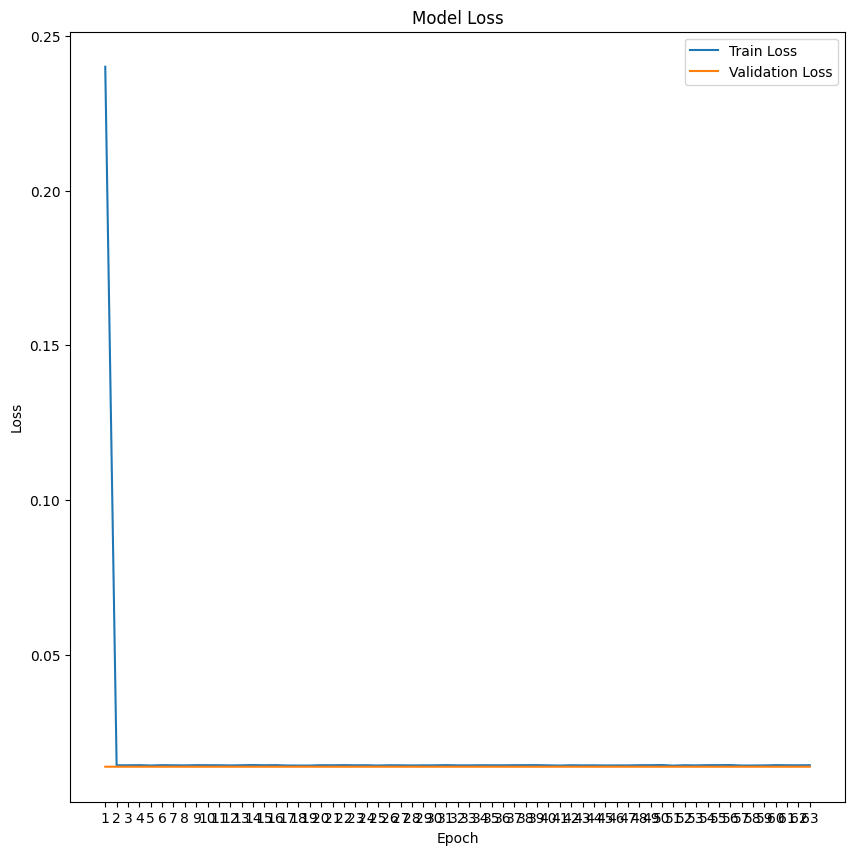

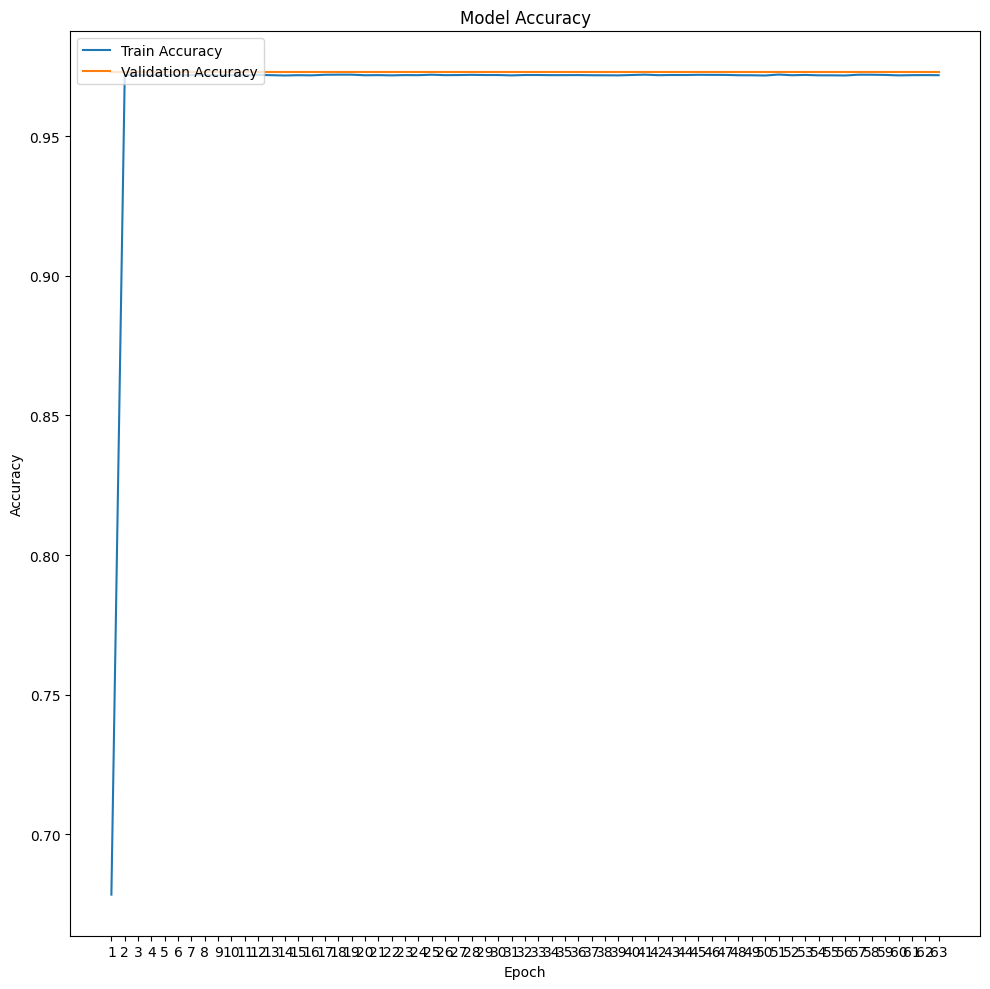

In [31]:
import matplotlib.pyplot as plt

# Visualization of training history
def plot_history(history):
    epochs = range(1, len(history.history['loss']) + 1)  # Generate epoch indices

    plt.figure(figsize=(10, 10))
    
    # Plot training & validation loss values
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)  # Set x-axis ticks to every epoch
    plt.legend(loc='upper right')

    plt.show()
    plt.figure(figsize=(10, 10))
    # Plot training & validation accuracy values
    plt.plot(epochs, history.history['iou_metric'], label='Train Accuracy')
    plt.plot(epochs, history.history['val_iou_metric'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs)  # Set x-axis ticks to every epoch
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_history(history)

In [12]:
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [11]:
y_pred = model.predict(test_gen, steps=len(X_test) // batch_size)
y_pred.shape

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


(74, 32, 32, 16, 4)

In [32]:
random_image = images[50]
ground_truth_mask = masks[50]

# Add a batch dimension to the image (needed for model prediction)
image_batch = np.expand_dims(random_image, axis=0)

In [33]:
image_batch.shape

(1, 32, 32, 16, 4)

In [35]:
y_pred = model.predict(image_batch)
predicted_mask = np.squeeze(y_pred, axis=0)
# Convert probabilities to class labels
predicted_mask = np.argmax(predicted_mask, axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


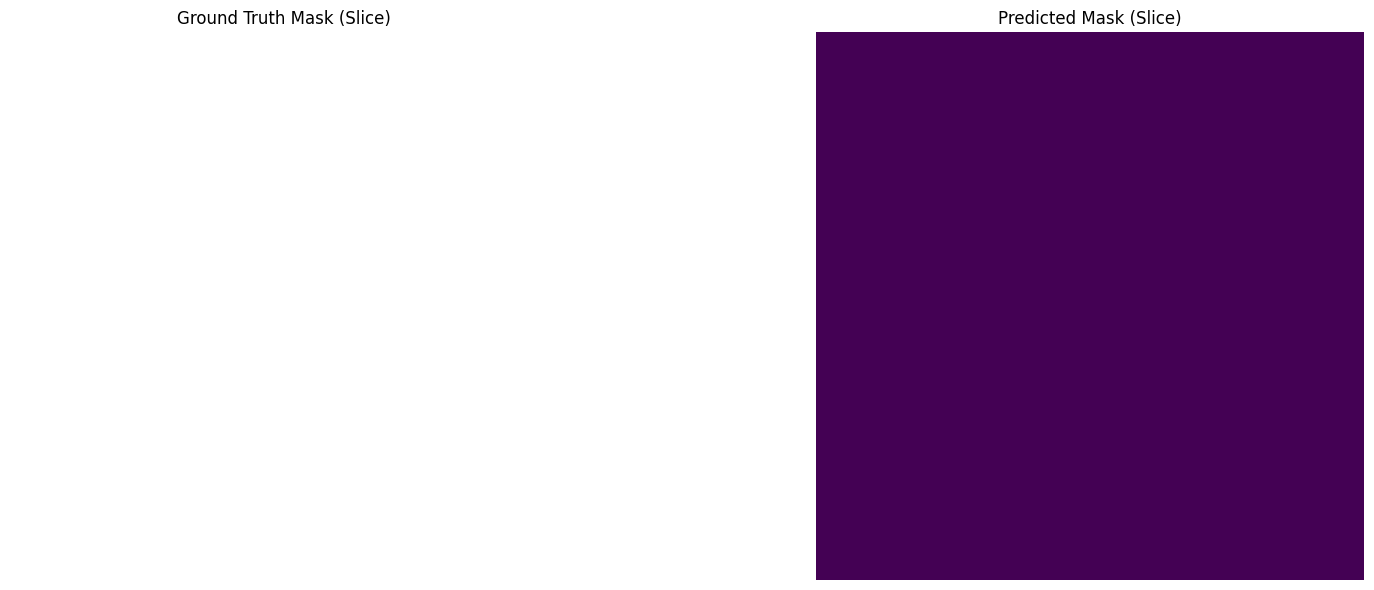

In [40]:
import matplotlib.pyplot as plt

# Select a specific slice to visualize (e.g., middle slice along z-axis)
slice_index = random_image.shape[-2] // 2  # Middle slice along the z-axis

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Display the ground truth mask (slice)
axes[0].imshow(ground_truth_mask[:, :, 6], cmap="viridis")
axes[0].set_title("Ground Truth Mask (Slice)")
axes[0].axis("off")

# Display the predicted mask (slice)
axes[1].imshow(predicted_mask[:, :, 6], cmap="viridis")
axes[1].set_title("Predicted Mask (Slice)")
axes[1].axis("off")

plt.tight_layout()
plt.show()